# COLUMNS DESCRIPTION

- **LoanNr_ChkDgt**: Identifier (Primary Key).
- **Name**: Borrower’s name.
- **City**: Borrower’s city.
- **State**: Borrower’s state.
- **Zip**: Borrower’s zip code.
- **Bank**: Name of the lending bank.
- **BankState**: State where the bank is located.
- **NAICS**: North American Industry Classification System (NAICS) code, representing the industry of the borrower.
- **ApprovalDate**: Date when the Small Business Administration (SBA) commitment was issued.
- **ApprovalFY**: Fiscal year in which the loan was approved.
- **Term**: Loan term in months.
- **NoEmp**: Number of employees in the borrowing business.
- **NewExist**: Indicates whether the business is existing or new:
  - `1` = Existing business  
  - `2` = New business  
- **CreateJob**: Number of jobs created as a result of the loan.
- **RetainedJob**: Number of jobs retained due to the loan.
- **FranchiseCode**: Franchise identifier. Values:
  - `00000` or `00001` = Not a franchise  
- **UrbanRural**: Classification of the business location:
  - `1` = Urban  
  - `2` = Rural  
  - `0` = Undefined  
- **RevLineCr**: Indicates if the loan is a revolving line of credit:
  - `Y` = Yes  
  - `N` = No  
- **LowDoc**: Indicates participation in the LowDoc Loan Program:
  - `Y` = Yes  
  - `N` = No  
- **ChgOffDate**: The date when the loan was declared in default (charged-off).
- **DisbursementDate**: Date when the loan was disbursed.
- **DisbursementGross**: Total amount disbursed.
- **BalanceGross**: Outstanding gross balance.
- **MIS_Status**: Loan repayment status:
  - `CHGOFF` = Charged-off (defaulted)  
  - `PIF` = Paid in full  
- **ChgOffPrinGr**: Amount of principal charged off (defaulted).
- **GrAppv**: Gross amount of the loan approved by the bank.
- **SBA_Appv**: SBA-guaranteed amount of the approved loan.


# FUNCTIONS

In [1]:
# Function to evaluate metrics
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Prediction over training set
    y_train_pred = model.predict(X_train)
    # Prediction over test set
    y_test_pred = model.predict(X_test)

    # Compute metrics over train and test set
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)

    print(f"Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    print(f"Train F1 Score: {train_f1:.4f}, Test F1 Score: {test_f1:.4f}")
    print("Classification Report (Train):")
    print(classification_report(y_train, y_train_pred))
    print("Classification Report (Test):")
    print(classification_report(y_test, y_test_pred))
    
    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Plot Confusion Matrix for Train and Test
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=ax[0], cbar=False, annot_kws={"size": 16})
    ax[0].set_title("Train Confusion Matrix")
    ax[0].set_xlabel('Predicted')
    ax[0].set_ylabel('Actual')
    
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=ax[1], cbar=False, annot_kws={"size": 16})
    ax[1].set_title("Test Confusion Matrix")
    ax[1].set_xlabel('Predicted')
    ax[1].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

In [5]:
def shap_analysis(model, X_test, y_test, num_samples=3, flag = 0):
    explainer_model = shap.TreeExplainer(model)
    
    # Just for random forest for classification
    if(flag == 1):
        shap_values_model_raw = explainer_model.shap_values(X_test)
        shap_values_model = shap_values_model_raw[:, :, 1]

    else: shap_values_model = explainer_model.shap_values(X_test)
    
    # Check dimensions
    assert shap_values_model.shape == X_test.shape, "Dimension SHAP doesn't match with X_test"
    
    # Summary Plot
    plt.figure(figsize=(10, 5))
    print("Summary Plot")
    shap.summary_plot(shap_values_model, X_test)

    # SHAP Bar Plot (mean absolute value per feature)
    plt.figure(figsize=(10, 5))
    print("SHAP Bar Plot (Feature Importance)")
    shap.summary_plot(shap_values_model, X_test, plot_type="bar")
    
    # Dependence Plot
    for feature_name in X_test.columns:
        plt.figure(figsize=(10, 5))
        print(f"Dependence Plot for {feature_name}")
        shap.dependence_plot(feature_name, shap_values_model, X_test, interaction_index=None)

    '''
    # Force Plot
    for i in range(num_samples):
        observation_features = X_test.iloc[i]
         
        true_label = y_test.iloc[i]
        predicted_label = model.predict([observation_features])[0]
        
        print(f"Observation {i+1}:")
        print(f"  True label: {true_label}")
        print(f"  Predicted label: {predicted_label}")
        
        # Plot
        plt.figure(figsize=(10, 5))
        print(f"Force Plot for observation {i+1}")
        shap.plots.force(explainer_model.expected_value[0], shap_values_model[i], observation_features, matplotlib=True)
        plt.show()
    '''

In [7]:
def banzhaf_value(model, X, flag=1):
    
    # Initialize an array to store Banzhaf values for each feature
    n = X.shape[1] 
    banzhaf_values = np.zeros(n)  
    all_features = list(X.columns)
    
    # Iterate over all coalitions (combinations of features)
    for S in tqdm(range(1, 2**n), desc="Calculating Banzhaf Values", unit="coalition"): 
        
        coalition = [all_features[i] for i in range(n) if (S & (1 << i)) > 0]  # Here you are creating a binary code, if 1 then that feature is
        # included in the considered coalition, if 0 then it is excluded. The binary code is given by S written in binary
        
        # Set features not in the current coalition to NaN
        coalition_data = X.copy()
        for feature in all_features:
            if feature not in coalition:
                coalition_data[feature] = np.random.permutation(coalition_data[feature].values)
                
        pred_coalition = model.predict(coalition_data) # Get model predictions for the coalition
        
        # Iterate over each feature and calculate its marginal contribution to the coalition
        for i in range(n): 
            feature = all_features[i] 
            
            if feature in coalition:
                coalition_data_without_feature = coalition_data.copy()  # Create coalition without this feature
                coalition_data_without_feature[feature] = np.random.permutation(coalition_data_without_feature[feature].values)  
                # Permute Data without the feature
                
                # Get model predictions for the coalition without the current feature
                pred_without_feature = model.predict(coalition_data_without_feature)
                
                # Calculate the marginal contribution of the feature (difference in prediction)
                if(flag == 1): #classification
                    marginal_contribution = np.sum(np.abs(pred_coalition - pred_without_feature))  # Mean of the differences in predictions

                else: #regression
                    marginal_contribution = np.mean(np.abs(pred_coalition - pred_without_feature))
                
                # Add the marginal contribution to the Banzhaf value for the feature, normalized by the number of coalitions
                banzhaf_values[i] += marginal_contribution / (2**(n-1))
    
    # Save the Banzhaf values as a dictionary with feature names as keys
    banzhaf = dict(zip(all_features, banzhaf_values))
    
    # Print the Banzhaf values for each feature
    print("Banzhaf Values for each feature:")
    for feature, value in banzhaf.items():
        print(f"{feature}: {value:.4f}")

    # Sort the Banzhaf values in descending order
    sorted_features = sorted(banzhaf.items(), key=lambda x: x[1], reverse=True)

    # Unpack sorted values for plotting
    features_sorted, values_sorted = zip(*sorted_features)

    # Create a bar plot
    plt.figure(figsize=(10, 6))
    plt.barh(features_sorted, values_sorted, color='skyblue')
    plt.xlabel('Banzhaf Value')
    plt.ylabel('Feature')
    plt.title('Banzhaf Values for Each Feature')
    plt.gca().invert_yaxis()
    plt.show()

In [ ]:
# Imposta parametri
n_max_depth_max = 20  # Max numero di alberi
patience = 5  # Numero massimo di iterazioni senza miglioramento prima di fermarsi
best_oob_score = float('inf')  # Miglior OOB score trovato finora
no_improvement_count = 0  # Conta il numero di iterazioni senza miglioramento
oob_errors = []

# Fit iniziale del modello
best_rf = RandomForestClassifier(n_estimators=100, oob_score=True, max_depth = 5, random_state=19)
best_rf.fit(X_train, y_train)
oob_errors.append(1 - best_rf.oob_score_)

# Costruisci progressivamente il RandomForest aggiungendo alberi
for n_estimators in range(5, n_max_depth_max+ 1):
    # Aggiungi un altro albero
    best_rf.max_depth = n_estimators
    best_rf.fit(X_train, y_train)
    
    # Calcola l'errore OOB
    current_oob_error = 1 - best_rf.oob_score_
    oob_errors.append(current_oob_error)
    
    # Se l'errore OOB non è migliorato, interrompi il ciclo
    if current_oob_error >= best_oob_score:
        no_improvement_count += 1
    else:
        best_oob_score = current_oob_error
        no_improvement_count = 0

    # Se non c'è stato miglioramento per 'patience' iterazioni, fermati
    if no_improvement_count >= patience:
        print(f"Early stopping at {n_estimators} trees due to no improvement.")
        break

# Plot dei risultati
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(oob_errors) + 1), oob_errors, label="OOB error", color='blue')
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("OOB Error Rate")
plt.title("OOB Error Rate with Early Stopping")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# CLASSIFICATION

We aim at classify if a conceded loan was repaid or not.

## DATA PREPROCESSING

In [9]:
# Import libraries
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import mode
from imblearn.over_sampling import SMOTE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

In [10]:
# Load Data
df = pd.read_csv(r'C:\Users\albyp\Downloads\SBAnational.csv')

# Dataset info
print(df.head())
df.info()
print(df.isnull().sum())

C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\2537186366.py:2: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\albyp\Downloads\SBAnational.csv')


   LoanNr_ChkDgt                           Name          City State    Zip  \
0     1000014003                 ABC HOBBYCRAFT    EVANSVILLE    IN  47711   
1     1000024006    LANDMARK BAR & GRILLE (THE)     NEW PARIS    IN  46526   
2     1000034009          WHITLOCK DDS, TODD M.   BLOOMINGTON    IN  47401   
3     1000044001  BIG BUCKS PAWN & JEWELRY, LLC  BROKEN ARROW    OK  74012   
4     1000054004    ANASTASIA CONFECTIONS, INC.       ORLANDO    FL  32801   

                            Bank BankState   NAICS ApprovalDate ApprovalFY  \
0               FIFTH THIRD BANK        OH  451120    28-Feb-97       1997   
1                1ST SOURCE BANK        IN  722410    28-Feb-97       1997   
2        GRANT COUNTY STATE BANK        IN  621210    28-Feb-97       1997   
3  1ST NATL BK & TR CO OF BROKEN        OK       0    28-Feb-97       1997   
4        FLORIDA BUS. DEVEL CORP        FL       0    28-Feb-97       1997   

   ...  RevLineCr  LowDoc  ChgOffDate  DisbursementDate  Disbu

We will focus only on 2010-2014 loans. We then remove useless features.

In [12]:
# We consider only observations from 2010 to 2014
df = df[df["ApprovalFY"].astype(str).str.isnumeric()]
df["ApprovalFY"] = df["ApprovalFY"].astype(int)
df = df[df["ApprovalFY"] >= 2010]

# Since they are unknown, we remove them
df = df[df["UrbanRural"] != 0]
df = df.dropna(subset=["MIS_Status"])

# Remove features
df = df.drop(columns=["LoanNr_ChkDgt", "Name", "City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalDate", "ApprovalFY", "FranchiseCode",
                     "ChgOffDate", "DisbursementDate", "ChgOffPrinGr", "BalanceGross"])

# Convert categorical columns to 0 and 1
df["UrbanRural"] = df["UrbanRural"].map({1: 1, 2: 0})
df["NewExist"] = df["NewExist"].map({1: 1, 2: 0})
df["RevLineCr"] = df["RevLineCr"].map({"Y": 1, "N": 0})
df["LowDoc"] = df["LowDoc"].map({"Y": 1, "N": 0})
df["MIS_Status"] = df["MIS_Status"].map({"CHGOFF": 1, "P I F": 0})

# Convert the columns to 'object' type (if needed)
df["UrbanRural"] = df["UrbanRural"].astype("object")
df["NewExist"] = df["NewExist"].astype("object")
df["RevLineCr"] = df["RevLineCr"].astype("object")
df["LowDoc"] = df["LowDoc"].astype("object")
df["MIS_Status"] = df["MIS_Status"].astype("object")

# Remove non-numeric characters (e.g., "$", ",") and convert to float
df["DisbursementGross"] = pd.to_numeric(df["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
df["GrAppv"] = pd.to_numeric(df["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
df["SBA_Appv"] = pd.to_numeric(df["SBA_Appv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')

print(df.shape)
print(df.isnull().sum())
df.dtypes

<>:29: SyntaxWarning: invalid escape sequence '\$'
<>:30: SyntaxWarning: invalid escape sequence '\$'
<>:31: SyntaxWarning: invalid escape sequence '\$'
<>:29: SyntaxWarning: invalid escape sequence '\$'
<>:30: SyntaxWarning: invalid escape sequence '\$'
<>:31: SyntaxWarning: invalid escape sequence '\$'
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\3091187922.py:29: SyntaxWarning: invalid escape sequence '\$'
  df["DisbursementGross"] = pd.to_numeric(df["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\3091187922.py:30: SyntaxWarning: invalid escape sequence '\$'
  df["GrAppv"] = pd.to_numeric(df["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\3091187922.py:31: SyntaxWarning: invalid escape sequence '\$'
  df["SBA_Appv"] = pd.to_numeric(df["SBA_Appv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')


(38136, 12)
Term                    0
NoEmp                   0
NewExist              134
CreateJob               0
RetainedJob             0
UrbanRural              0
RevLineCr             832
LowDoc               1382
DisbursementGross       0
MIS_Status              0
GrAppv                  0
SBA_Appv                0
dtype: int64


Term                   int64
NoEmp                  int64
NewExist              object
CreateJob              int64
RetainedJob            int64
UrbanRural            object
RevLineCr             object
LowDoc                object
DisbursementGross    float64
MIS_Status            object
GrAppv               float64
SBA_Appv             float64
dtype: object

## DATA VISUALIZATION

We first compute correlation matrix and remove highly correlated variables.

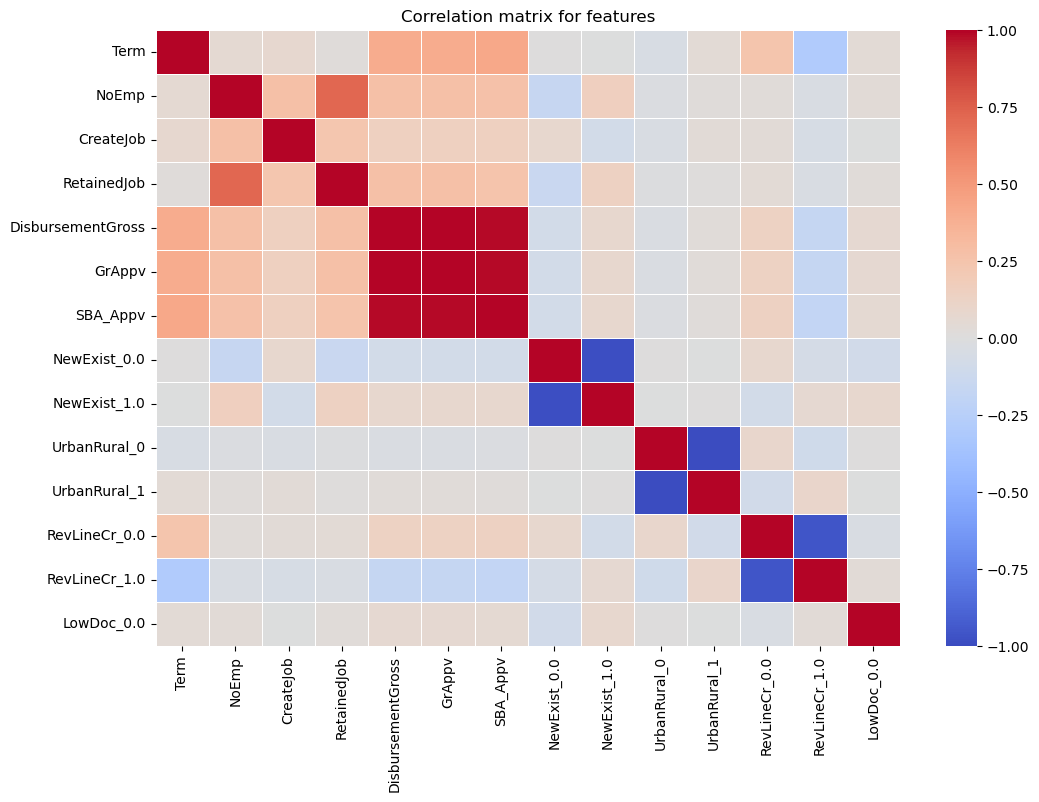

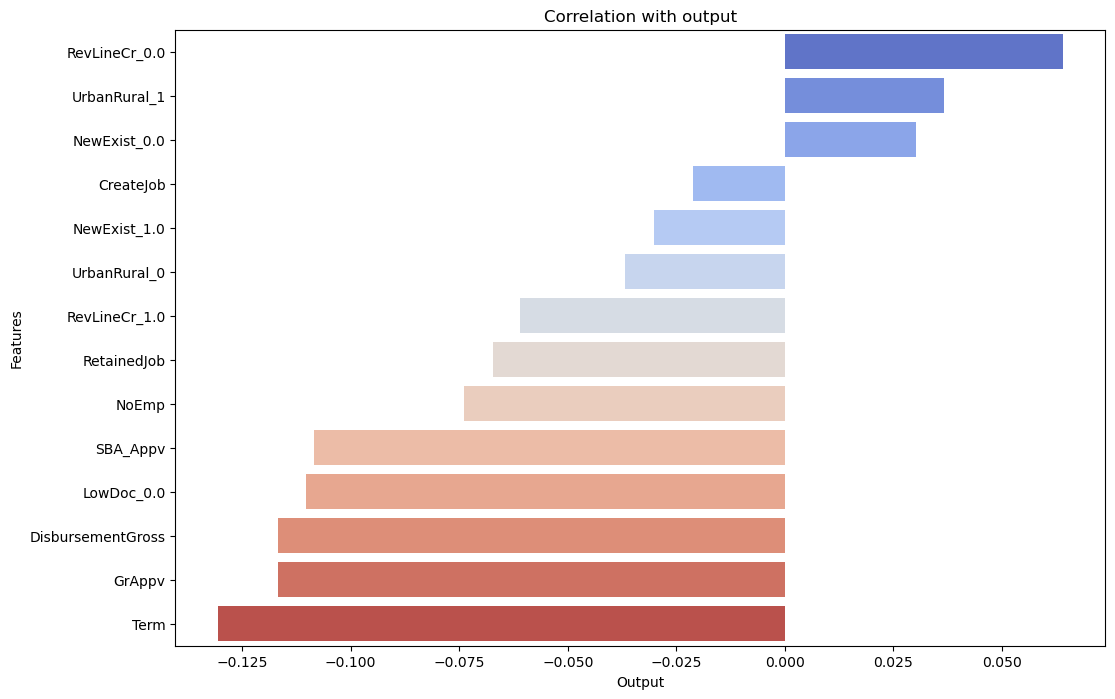

In [15]:
# Consider just features and perform one-hot encoding for categorical ones
df_features = df.drop(columns = 'MIS_Status')
df_encoded = pd.get_dummies(df_features, drop_first = False)
features_corr = df_encoded.corr()

# Correlation between features and output
df_encoded_with_output = df_encoded.copy()
df_encoded_with_output['MIS_Status'] = df['MIS_Status']
y_corr = df_encoded_with_output.corr()['MIS_Status'].drop('MIS_Status') 

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(features_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix for features")
plt.show()

plt.figure(figsize=(12, 8))
y_corr_sorted = y_corr.sort_values(ascending=False)
sns.barplot(x=y_corr_sorted.values, y=y_corr_sorted.index, palette='coolwarm', hue = y_corr_sorted.index, legend=False)

plt.xlabel("Output")
plt.ylabel("Features")
plt.title("Correlation with output")
plt.show()

df = df.drop(columns=["GrAppv", "SBA_Appv"])

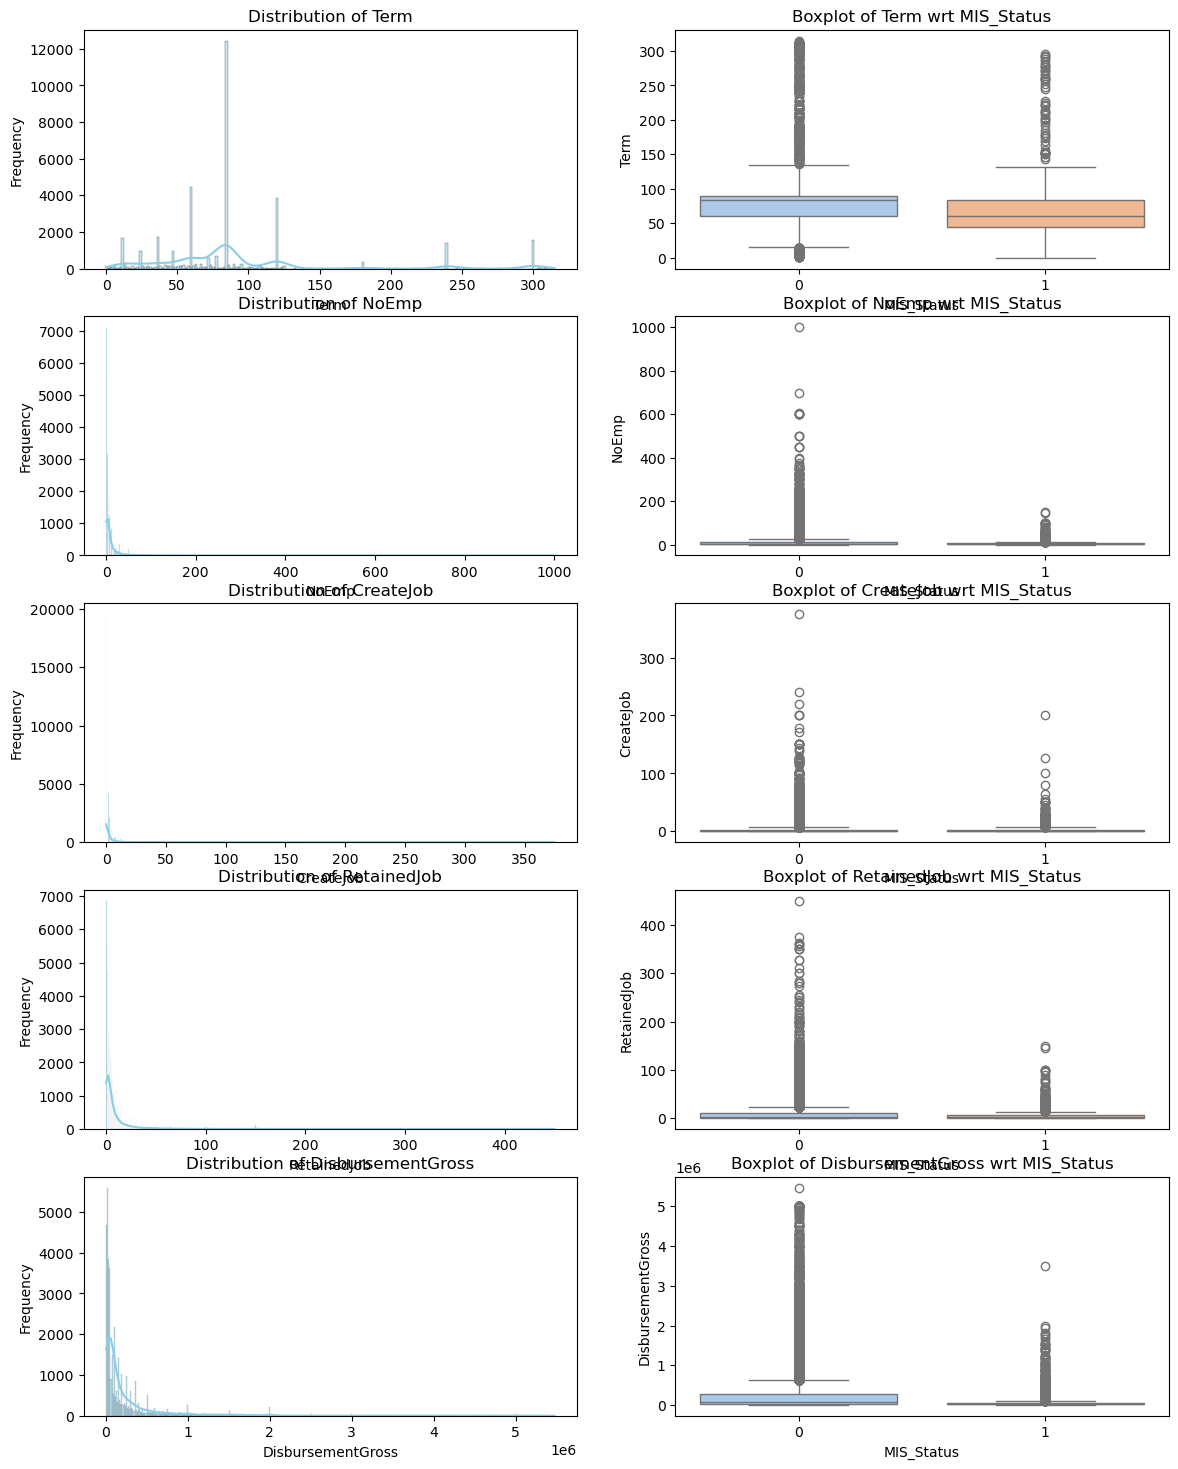

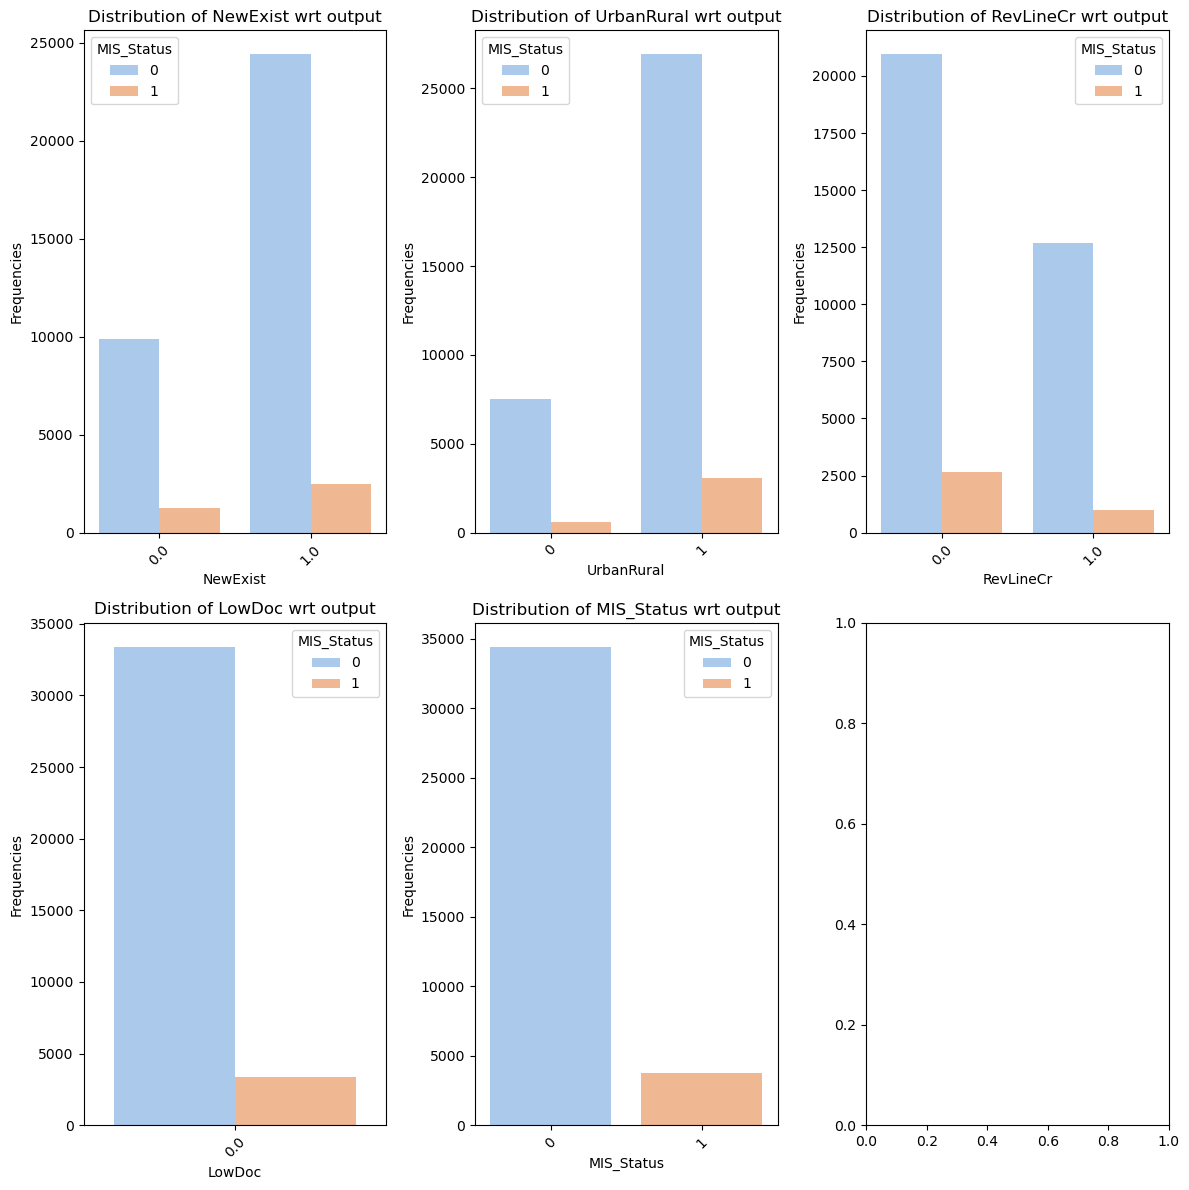

In [17]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

# Plot of numerical features along with boxplots wrt output
fig, axes = plt.subplots(5, 2, figsize=(14, 18)) 
axes = axes.ravel()

# Plot distribution for numerical variables on the left
for i, col in enumerate(num_cols):
    sns.histplot(df[col], kde=True, color='skyblue', ax=axes[2*i])
    axes[2*i].set_title(f"Distribution of {col}")
    axes[2*i].set_xlabel(col)
    axes[2*i].set_ylabel("Frequency")

# Plot boxplot for numerical variables with respect to target on the right
for i, col in enumerate(num_cols):
    sns.boxplot(x=df['MIS_Status'], y=df[col], palette='pastel', ax=axes[2*i+1], hue = df['MIS_Status'], legend = False)
    axes[2*i+1].set_title(f"Boxplot of {col} wrt MIS_Status")
    axes[2*i+1].set_xlabel("MIS_Status")
    axes[2*i+1].set_ylabel(col)

# Frequencies for each categorical variable wrt target
fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df[col], hue=df['MIS_Status'], palette='pastel', ax=axes[i])
    axes[i].set_title(f"Distribution of {col} wrt output")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequencies")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

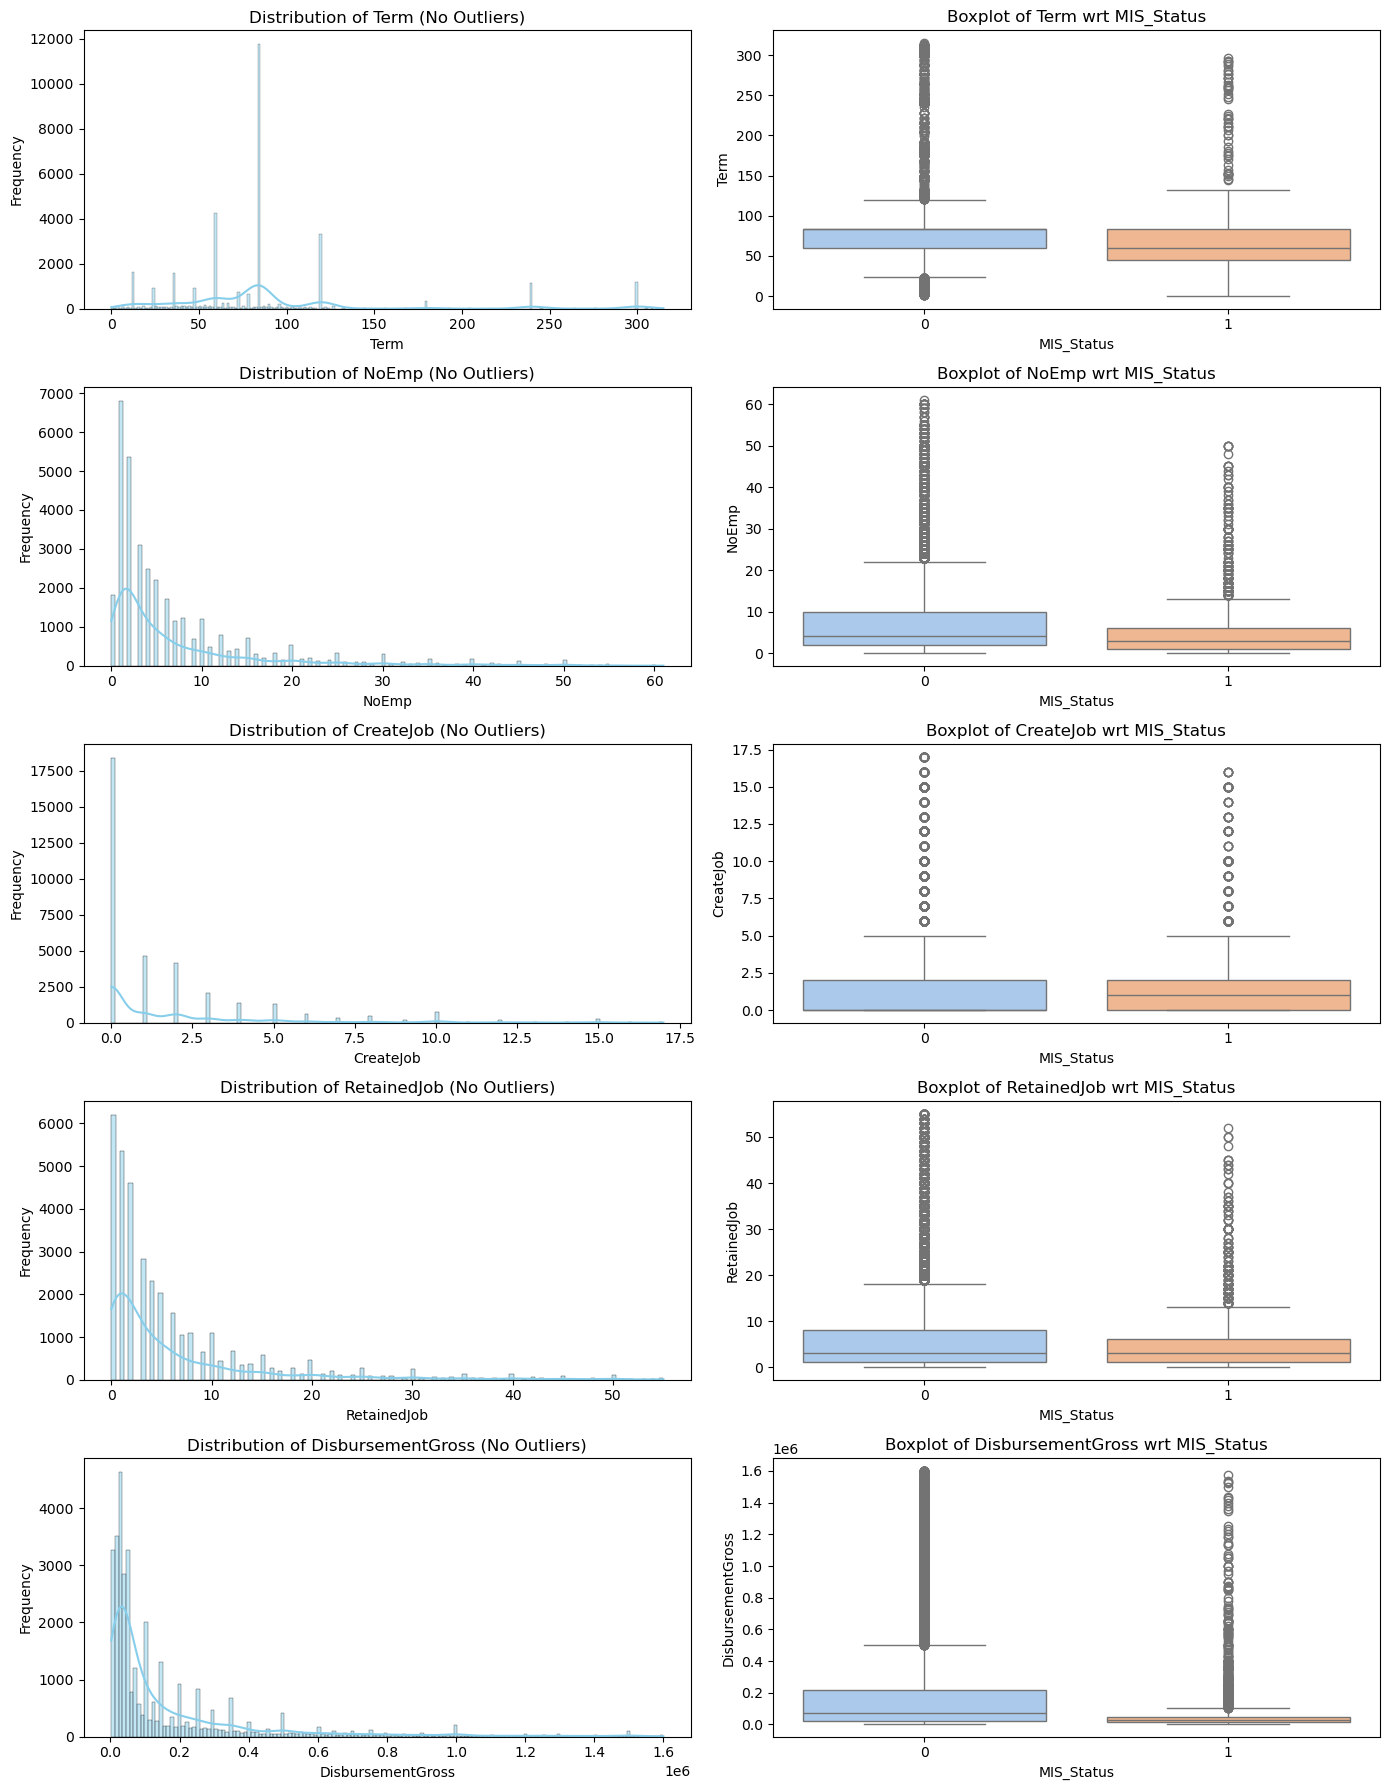

In [18]:
# Due to difficult in visualization, remove outliers from numerical variables
Q1 = df[num_cols].quantile(0.1)
Q3 = df[num_cols].quantile(0.9)
IQR = Q3 - Q1
df_no_outliers = df.copy()

for col in num_cols:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

# Plot
fig, axes = plt.subplots(5, 2, figsize=(14, 18)) 
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(df_no_outliers[col], kde=True, color='skyblue', ax=axes[2*i])
    axes[2*i].set_title(f"Distribution of {col} (No Outliers)")
    axes[2*i].set_xlabel(col)
    axes[2*i].set_ylabel("Frequency")

for i, col in enumerate(num_cols):
    sns.boxplot(x=df_no_outliers['MIS_Status'], y=df_no_outliers[col], palette='pastel', ax=axes[2*i+1], 
                hue = df_no_outliers['MIS_Status'], legend = False)
    axes[2*i+1].set_title(f"Boxplot of {col} wrt MIS_Status")
    axes[2*i+1].set_xlabel("MIS_Status")
    axes[2*i+1].set_ylabel(col)

plt.tight_layout()
plt.show()

## PREDICTION

In [21]:
# Set seed
np.random.seed(19)

# One-hot encoding for categorical variables
df["MIS_Status"] = df["MIS_Status"].astype(int)
df_encoded = pd.get_dummies(df, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop(columns=['MIS_Status'])
y = df_encoded['MIS_Status'].astype(int)

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Splitting the dataset in 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (26695, 8)
Test set: (11441, 8)


### RANDOM FOREST

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters for Random Forest:
{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 150}
Train Accuracy: 0.9771, Test Accuracy: 0.9377
Train F1 Score: 0.8920, Test F1 Score: 0.6869
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     24103
           1       0.82      0.97      0.89      2592

    accuracy                           0.98     26695
   macro avg       0.91      0.98      0.94     26695
weighted avg       0.98      0.98      0.98     26695

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10314
           1       0.68      0.69      0.69      1127

    accuracy                           0.94     11441
   macro avg       0.82      0.83      0.83     11441
weighted avg       0.94      0.94      0.94     11441



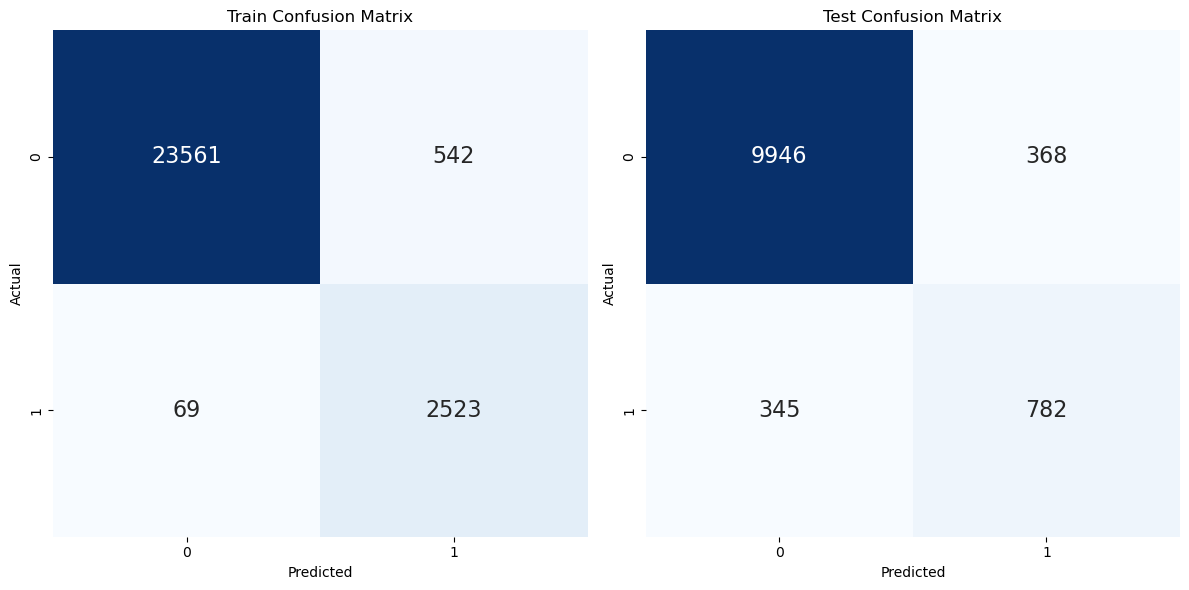

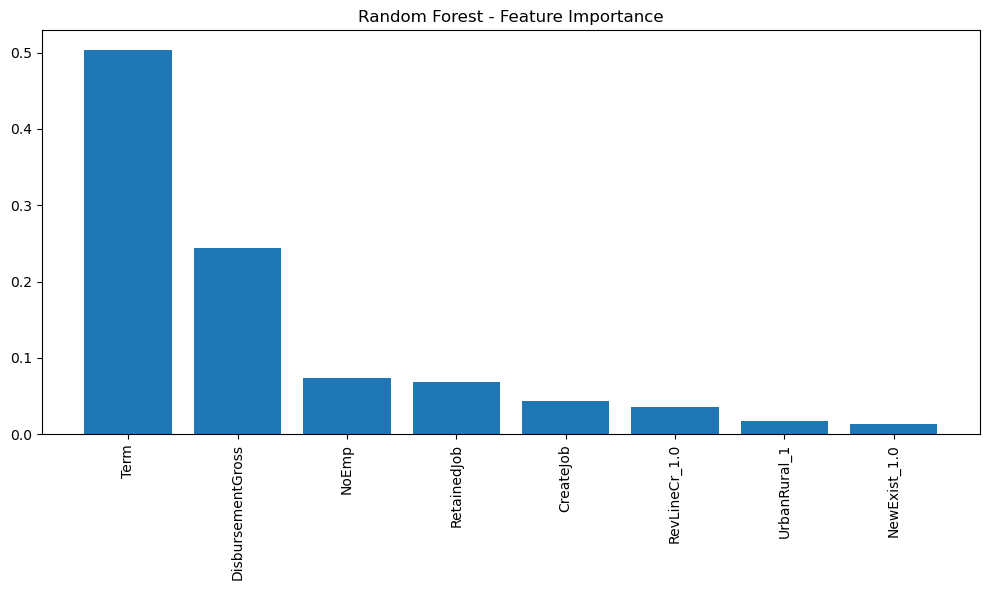

Summary Plot


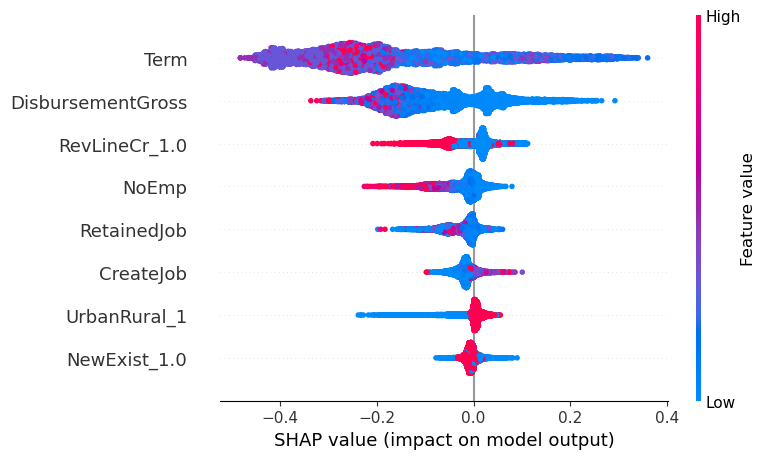

SHAP Bar Plot (Feature Importance)


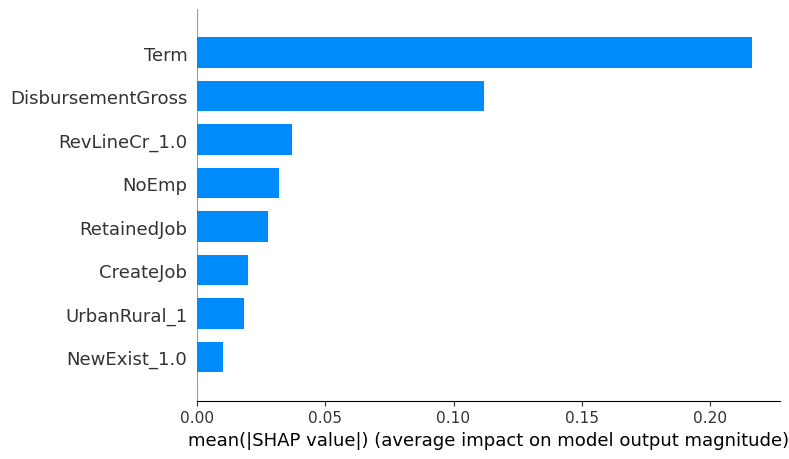

Dependence Plot for Term


<Figure size 1000x500 with 0 Axes>

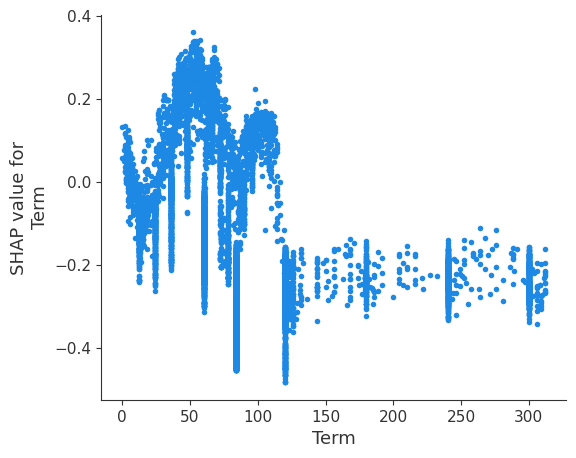

Dependence Plot for NoEmp


<Figure size 1000x500 with 0 Axes>

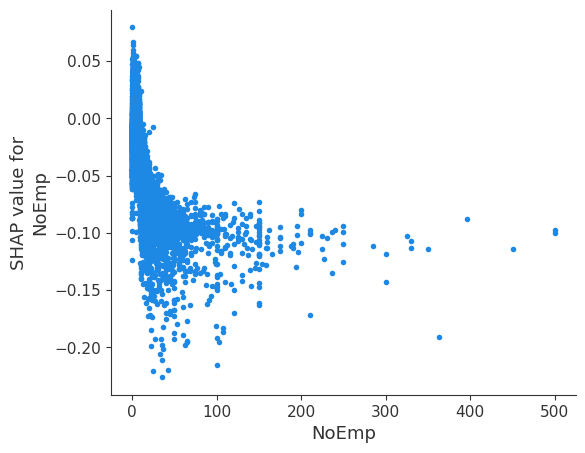

Dependence Plot for CreateJob


<Figure size 1000x500 with 0 Axes>

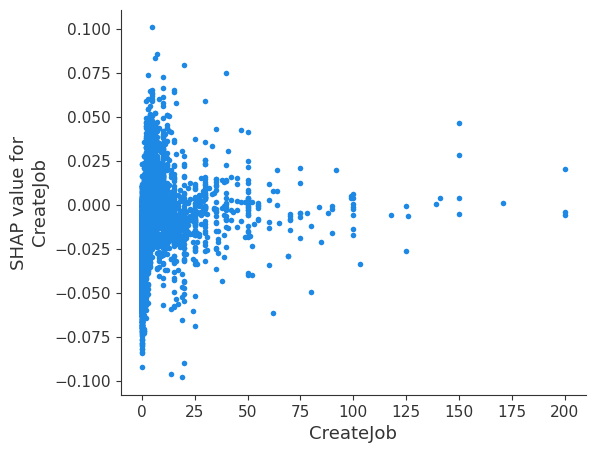

Dependence Plot for RetainedJob


<Figure size 1000x500 with 0 Axes>

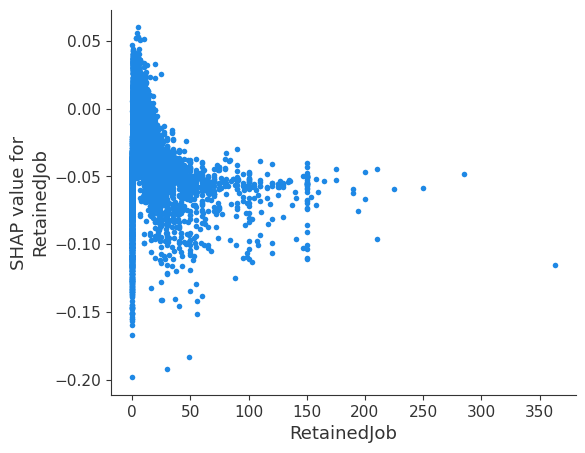

Dependence Plot for DisbursementGross


<Figure size 1000x500 with 0 Axes>

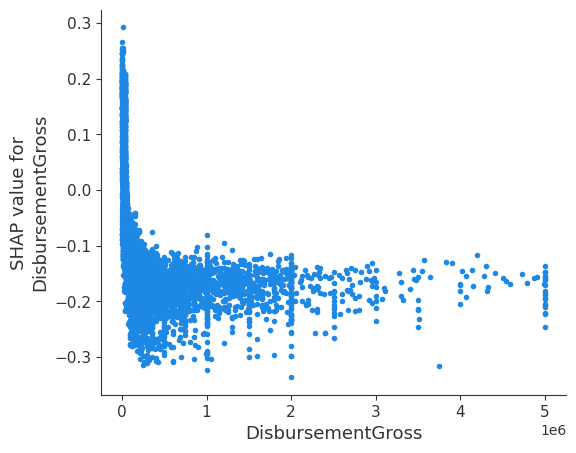

Dependence Plot for NewExist_1.0


<Figure size 1000x500 with 0 Axes>

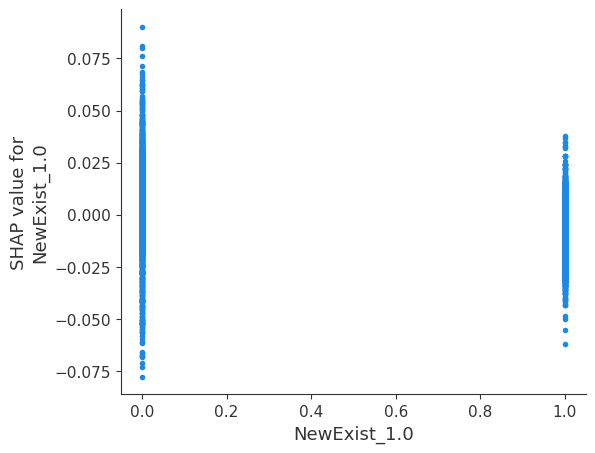

Dependence Plot for UrbanRural_1


<Figure size 1000x500 with 0 Axes>

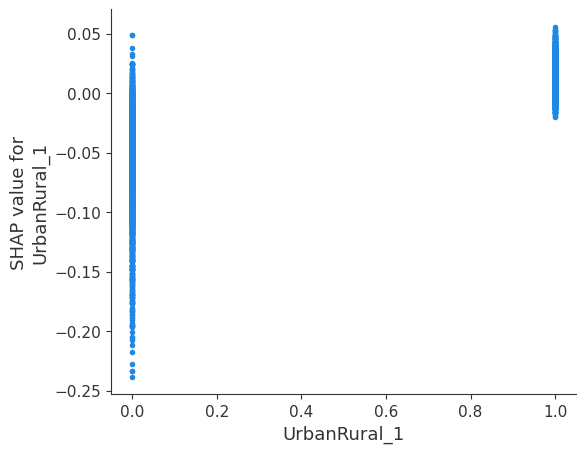

Dependence Plot for RevLineCr_1.0


<Figure size 1000x500 with 0 Axes>

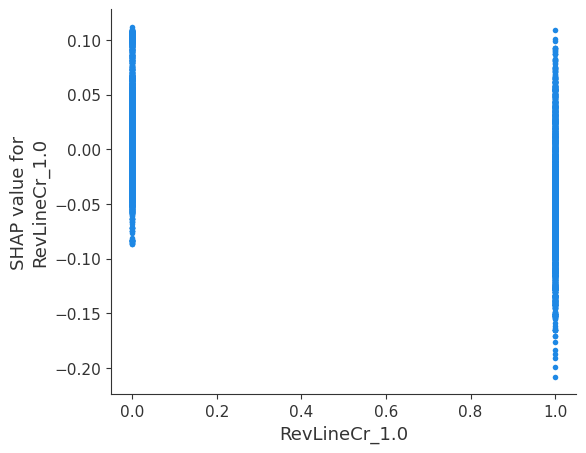

Calculating Banzhaf Values: 100%|██████████| 255/255 [06:48<00:00,  1.60s/coalition]

Banzhaf Values for each feature:
Term: 1348.2188
NoEmp: 418.0938
CreateJob: 281.3984
RetainedJob: 347.5859
DisbursementGross: 930.0625
NewExist_1.0: 171.0078
UrbanRural_1: 265.7891
RevLineCr_1.0: 402.1406


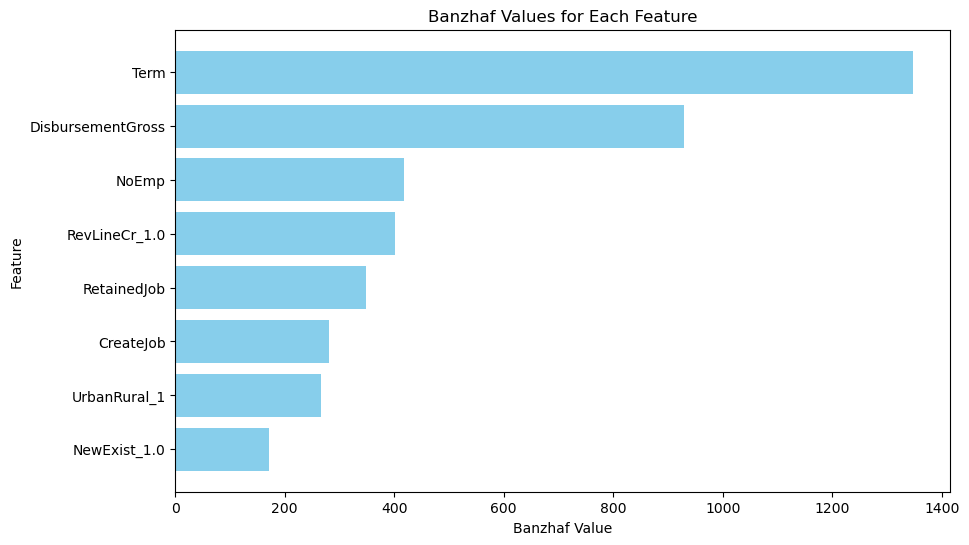

In [23]:
# If class imbalance
rf = RandomForestClassifier(class_weight = 'balanced', random_state=19)

# Random Forest Classifier
#rf = RandomForestClassifier(random_state=19)

# Grid of parameters to search
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [3]
}

# GridSearch
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)
print("Best parameters for Random Forest:")
print(grid_search_rf.best_params_)

# Model performances
best_rf = grid_search_rf.best_estimator_
evaluate_model(best_rf, X_train, X_test, y_train, y_test)

# Importance plot
importances_rf = best_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# SHAP
shap_analysis(best_rf, X_test, y_test, 3, 1)

# Banzhaf
banzhaf_value(best_rf, X_test, 1)

### XGBOOST

Fitting 5 folds for each of 32 candidates, totalling 160 fits


C:\Users\albyp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost:
{'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 20, 'n_estimators': 200, 'scale_pos_weight': 9.298996913580247, 'subsample': 0.7}
Train Accuracy: 0.9907, Test Accuracy: 0.9524
Train F1 Score: 0.9540, Test F1 Score: 0.7698
Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     24103
           1       0.91      1.00      0.95      2592

    accuracy                           0.99     26695
   macro avg       0.96      0.99      0.97     26695
weighted avg       0.99      0.99      0.99     26695

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.98      0.97      0.97     10314
           1       0.73      0.81      0.77      1127

    accuracy                           0.95     11441
   macro avg       0.86      0.89      0.87     11441
weighted avg       0.95      0.95      0.95     11441



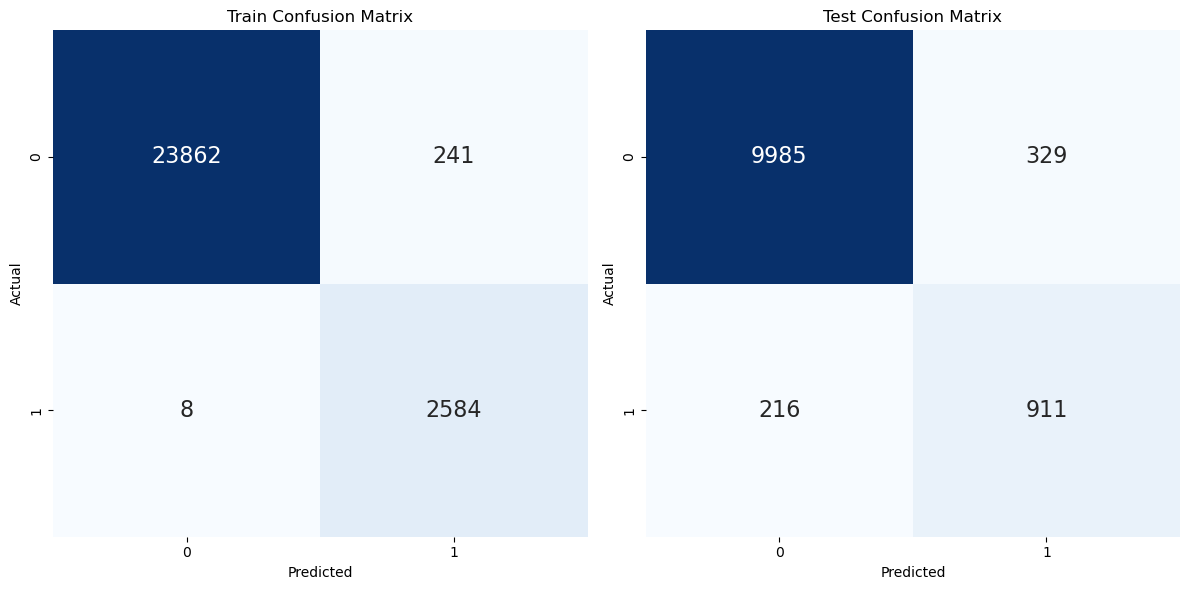

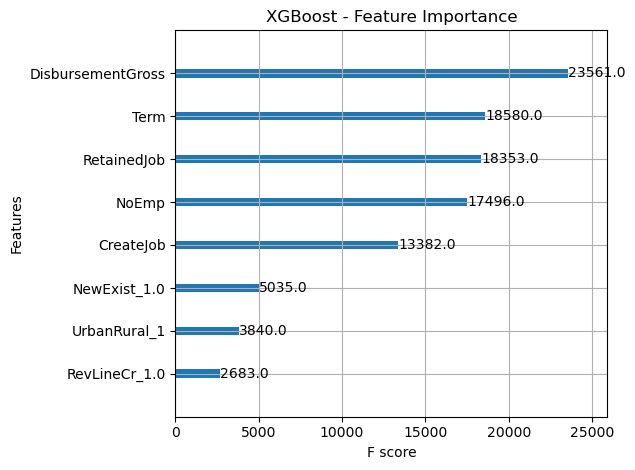

Summary Plot


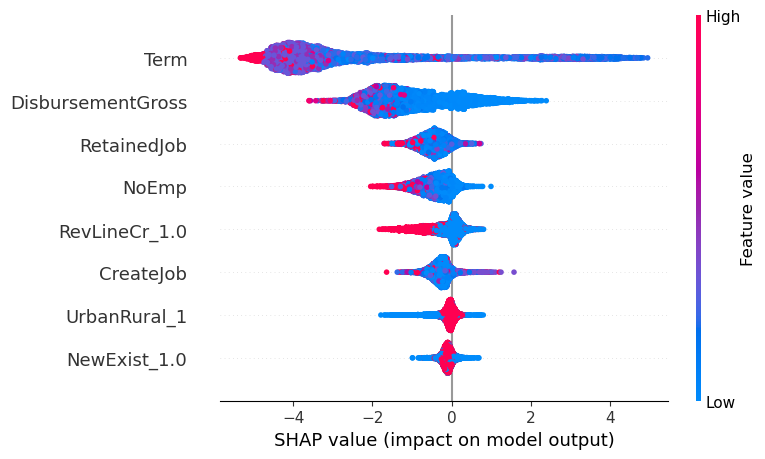

SHAP Bar Plot (Feature Importance)


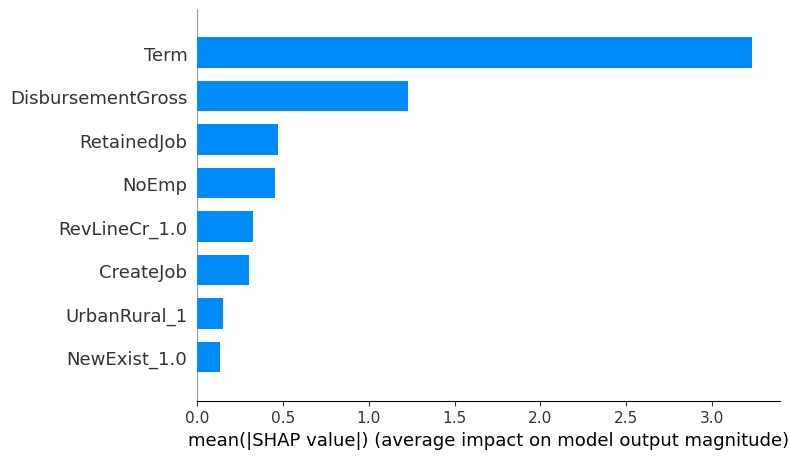

Dependence Plot for Term


<Figure size 1000x500 with 0 Axes>

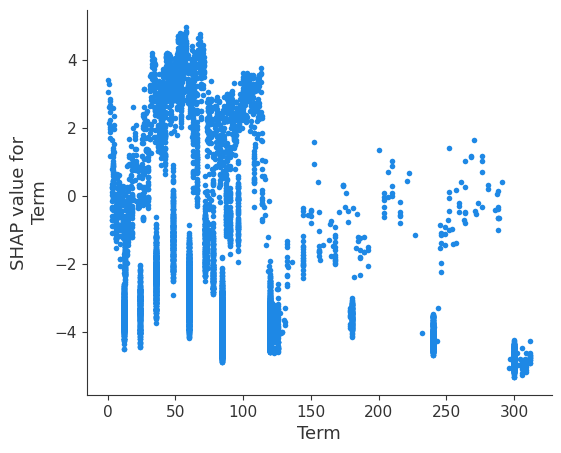

Dependence Plot for NoEmp


<Figure size 1000x500 with 0 Axes>

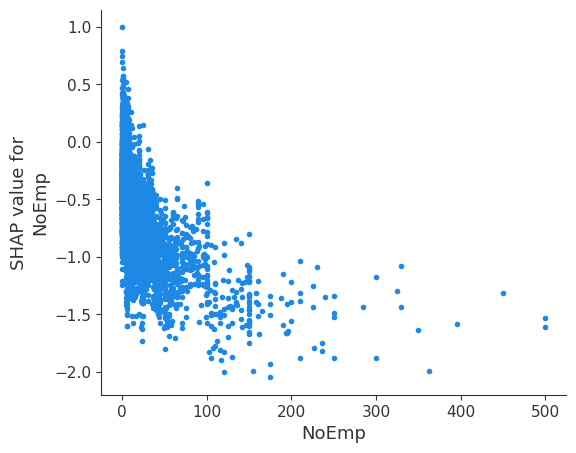

Dependence Plot for CreateJob


<Figure size 1000x500 with 0 Axes>

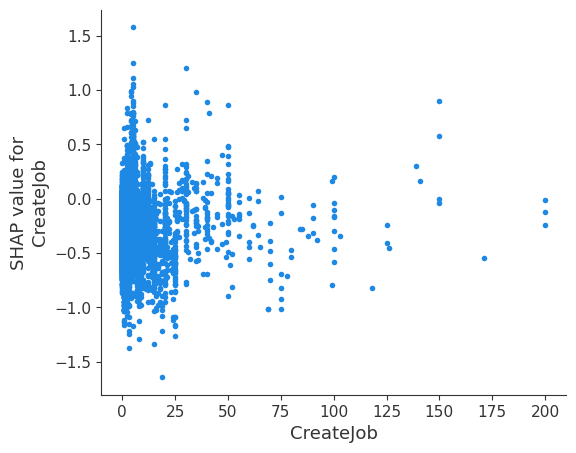

Dependence Plot for RetainedJob


<Figure size 1000x500 with 0 Axes>

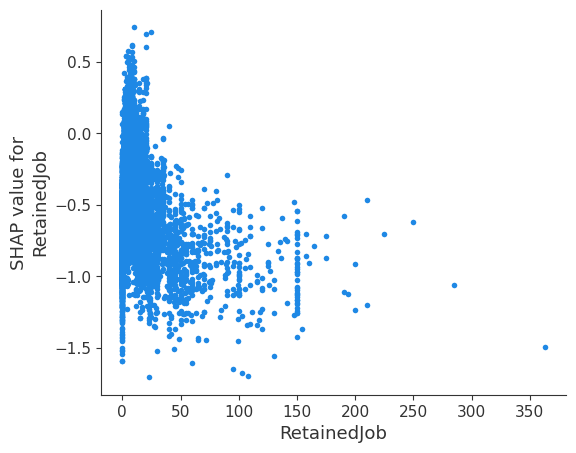

Dependence Plot for DisbursementGross


<Figure size 1000x500 with 0 Axes>

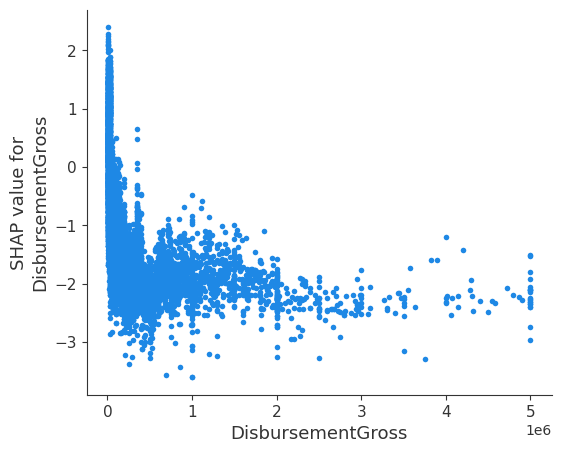

Dependence Plot for NewExist_1.0


<Figure size 1000x500 with 0 Axes>

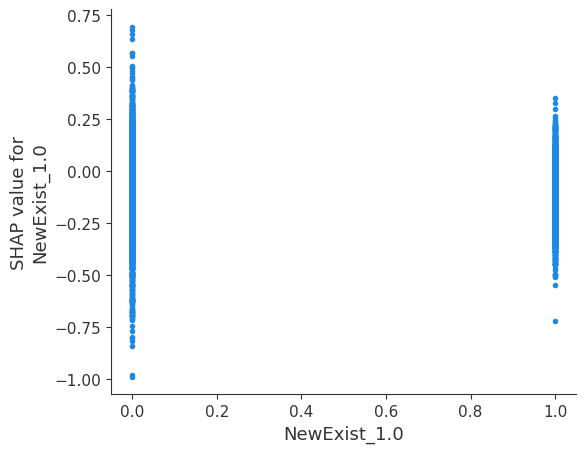

Dependence Plot for UrbanRural_1


<Figure size 1000x500 with 0 Axes>

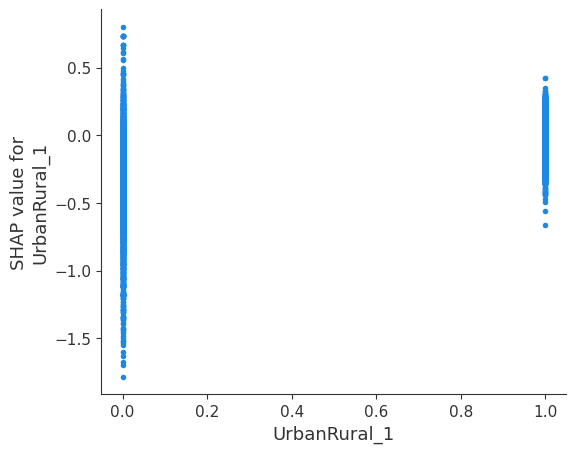

Dependence Plot for RevLineCr_1.0


<Figure size 1000x500 with 0 Axes>

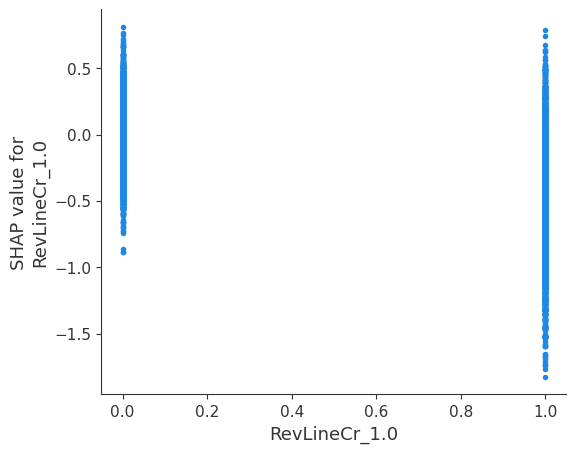

Calculating Banzhaf Values: 100%|██████████| 255/255 [01:39<00:00,  2.57coalition/s]


Banzhaf Values for each feature:
Term: 1929.5781
NoEmp: 274.6328
CreateJob: 189.0234
RetainedJob: 279.6094
DisbursementGross: 667.4375
NewExist_1.0: 124.1172
UrbanRural_1: 146.0312
RevLineCr_1.0: 260.0781


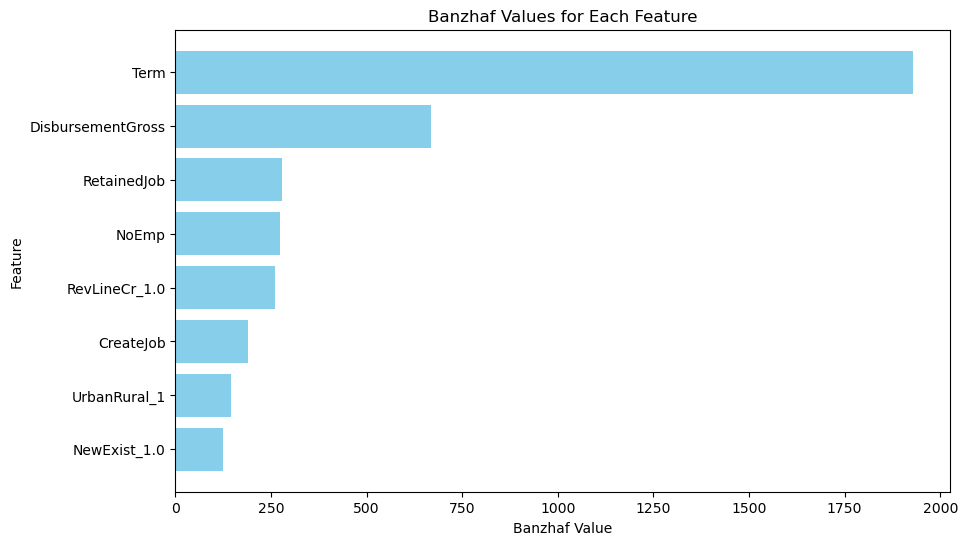

In [24]:
# If class imbalance
class_counts = Counter(y_train)
scale_pos_weight = class_counts[0] / class_counts[1] 

# XGBoost Classifier
xgb_model = XGBClassifier(random_state=19, use_label_encoder=False, eval_metric='logloss')

param_grid_xgb = {
    'n_estimators': [150, 200],
    'max_depth': [15, 20],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'scale_pos_weight': [scale_pos_weight]
}

# GridSearch
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)

# Model performances
best_xgb = grid_search_xgb.best_estimator_
evaluate_model(best_xgb, X_train, X_test, y_train, y_test)

# Importance plot
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=10, title="XGBoost - Feature Importance")
plt.tight_layout()
plt.show()

# SHAP
shap_analysis(best_xgb, X_test, y_test, 3, 0)

# Banzhaf
banzhaf_value(best_xgb, X_test, 1)

# REGRESSION

We now aim at evaluate how much was lost in percentage for each loan by the bank.

## DATA PREPROCESSING 

In [26]:
# Load Data
df_reg = pd.read_csv(r'C:\Users\albyp\Downloads\SBAnational.csv')
df_reg = df_reg[df_reg["ApprovalFY"].astype(str).str.isnumeric()]
df_reg["ApprovalFY"] = df_reg["ApprovalFY"].astype(int)
df_reg = df_reg[df_reg["ApprovalFY"] >= 2010]

# Since they are unknown, we remove them
df_reg = df_reg[df_reg["UrbanRural"] != 0]
df_reg = df_reg.dropna(subset=["MIS_Status"])

# Remove features
df_reg = df_reg.drop(columns=["LoanNr_ChkDgt", "Name", "City", "State", "Zip", "Bank", "BankState", "NAICS", "ApprovalDate", "ApprovalFY", 
                              "FranchiseCode", "ChgOffDate", "DisbursementDate", "BalanceGross"])

# Remove non-numeric characters (e.g., "$", ",") and convert to float for financial columns
df_reg["DisbursementGross"] = pd.to_numeric(df_reg["DisbursementGross"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
df_reg["GrAppv"] = pd.to_numeric(df_reg["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
df_reg["SBA_Appv"] = pd.to_numeric(df_reg["SBA_Appv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
df_reg["ChgOffPrinGr"] = pd.to_numeric(df_reg["ChgOffPrinGr"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')

# Convert categorical columns to 0 and 1
df_reg["UrbanRural"] = df_reg["UrbanRural"].map({1: 1, 2: 0})
df_reg["NewExist"] = df_reg["NewExist"].map({1: 1, 2: 0})
df_reg["RevLineCr"] = df_reg["RevLineCr"].map({"Y": 1, "N": 0})
df_reg["LowDoc"] = df_reg["LowDoc"].map({"Y": 1, "N": 0})
df_reg["MIS_Status"] = df_reg["MIS_Status"].map({"CHGOFF": 1, "P I F": 0})

# Convert columns to 'object' type if needed
df_reg["UrbanRural"] = df_reg["UrbanRural"].astype("object")
df_reg["NewExist"] = df_reg["NewExist"].astype("object")
df_reg["RevLineCr"] = df_reg["RevLineCr"].astype("object")
df_reg["LowDoc"] = df_reg["LowDoc"].astype("object")
df_reg["MIS_Status"] = df_reg["MIS_Status"].astype("object")

# Keep only defaulted observations
df_reg = df_reg[df_reg["MIS_Status"] == 1]
df_reg = df_reg.drop(columns=["MIS_Status"])
print(df_reg.shape)

<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
<>:16: SyntaxWarning: invalid escape sequence '\$'
<>:17: SyntaxWarning: invalid escape sequence '\$'
<>:18: SyntaxWarning: invalid escape sequence '\$'
<>:19: SyntaxWarning: invalid escape sequence '\$'
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\290218950.py:16: SyntaxWarning: invalid escape sequence '\$'
  df_reg["DisbursementGross"] = pd.to_numeric(df_reg["DisbursementGross"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\290218950.py:17: SyntaxWarning: invalid escape sequence '\$'
  df_reg["GrAppv"] = pd.to_numeric(df_reg["GrAppv"].replace({'\$': '', ',': ''}, regex=True), errors='coerce')
C:\Users\albyp\AppData\Local\Temp\ipykernel_31084\290218950.py:18: SyntaxWarning: invalid escape sequence '\$'
  df_reg["SBA_A

(3719, 12)


We will try to predict (via regression) the percentage of the loan lost by the bank.

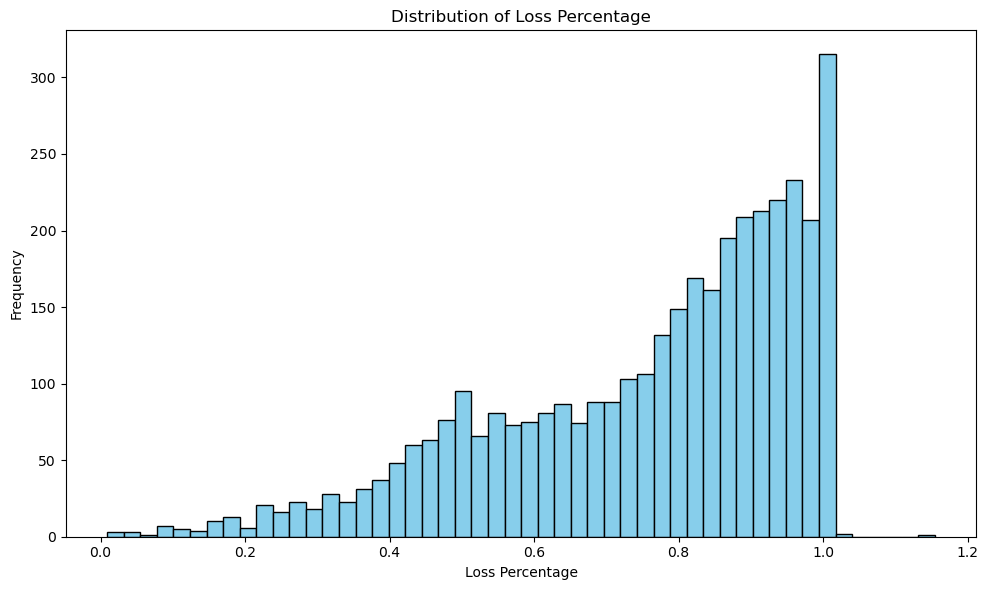

In [27]:
# Compute 'loss_percentage'
df_reg['loss_percentage'] = df_reg['ChgOffPrinGr'] / df_reg['DisbursementGross']

# Plot
plt.figure(figsize=(10, 6))
plt.hist(df_reg['loss_percentage'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Loss Percentage')
plt.xlabel('Loss Percentage')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [28]:
# Remove percentages higher than 100% since clear errors
df_reg = df_reg[df_reg['loss_percentage'] <= 1]
df_reg = df_reg.drop(columns=['ChgOffPrinGr'])

df_reg.shape

(3712, 12)

## DATA VISUALIZATION

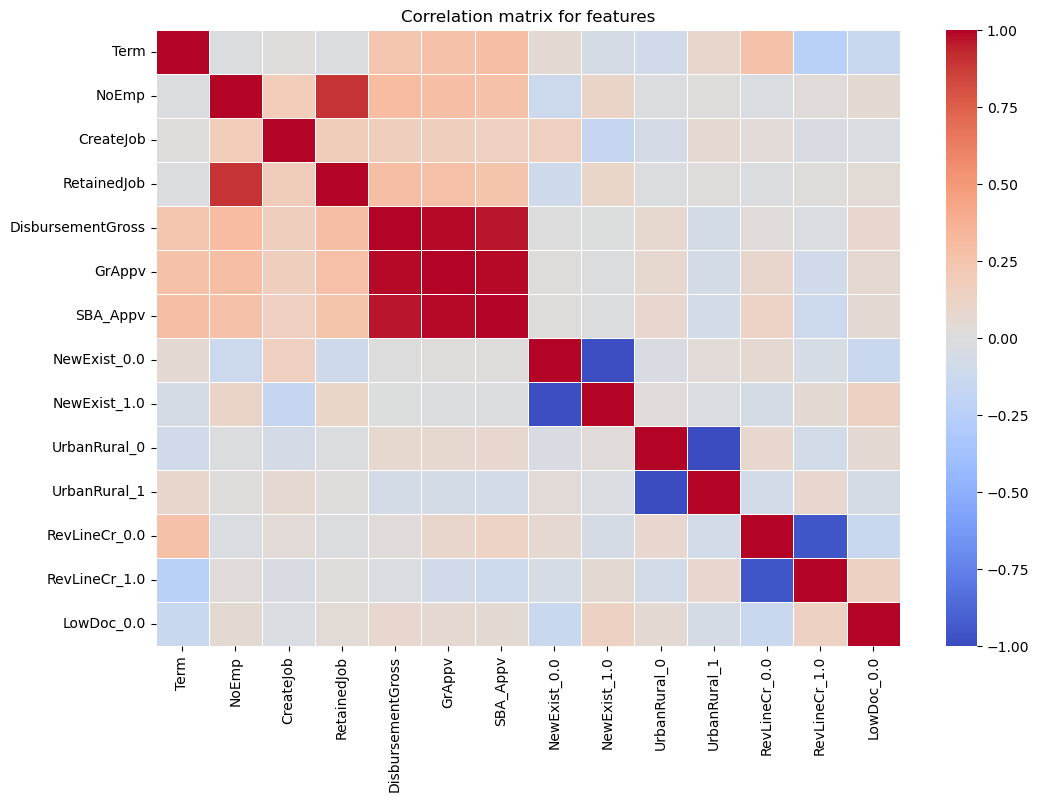

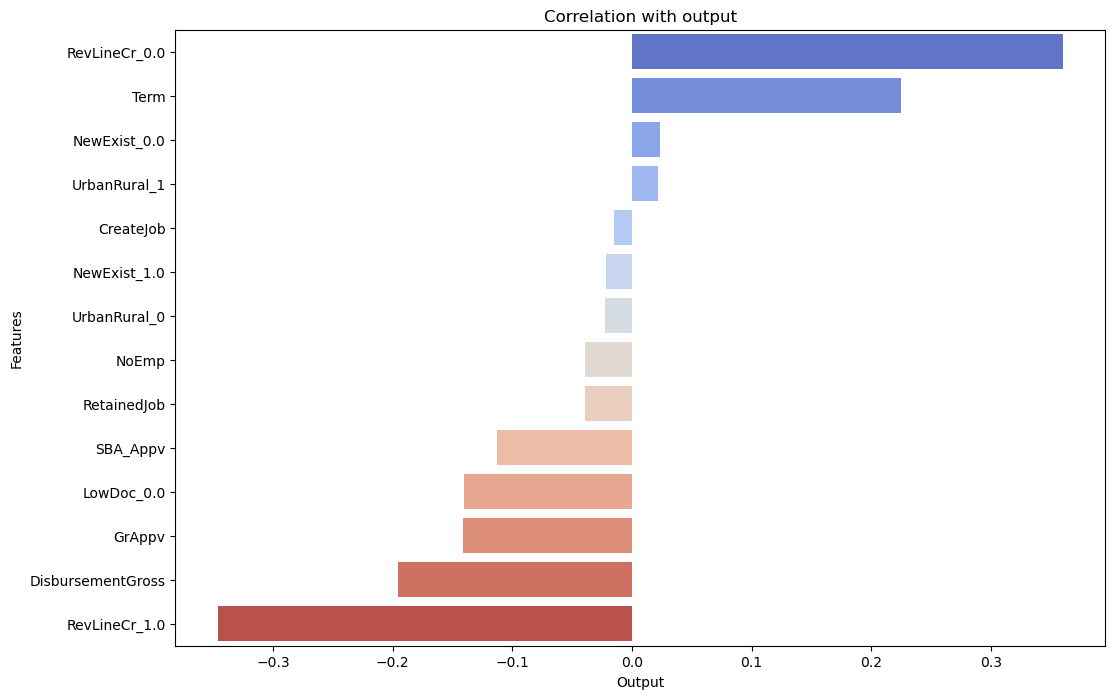

In [29]:
# Consider just features and perform one-hot encoding for categorical ones
df_features = df_reg.drop(columns = 'loss_percentage')
df_encoded = pd.get_dummies(df_features, drop_first = False)
features_corr = df_encoded.corr()

# Correlation between features and output
df_encoded_with_output = df_encoded.copy()
df_encoded_with_output['loss_percentage'] = df_reg['loss_percentage']
y_corr = df_encoded_with_output.corr()['loss_percentage'].drop('loss_percentage') 

# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(features_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=0.5)
plt.title("Correlation matrix for features")
plt.show()

plt.figure(figsize=(12, 8))
y_corr_sorted = y_corr.sort_values(ascending=False)
sns.barplot(x=y_corr_sorted.values, y=y_corr_sorted.index, palette='coolwarm', hue = y_corr_sorted.index, legend=False)

plt.xlabel("Output")
plt.ylabel("Features")
plt.title("Correlation with output")
plt.show()

# Remove highly correlated variables
df_reg = df_reg.drop(columns=["GrAppv", "SBA_Appv"])

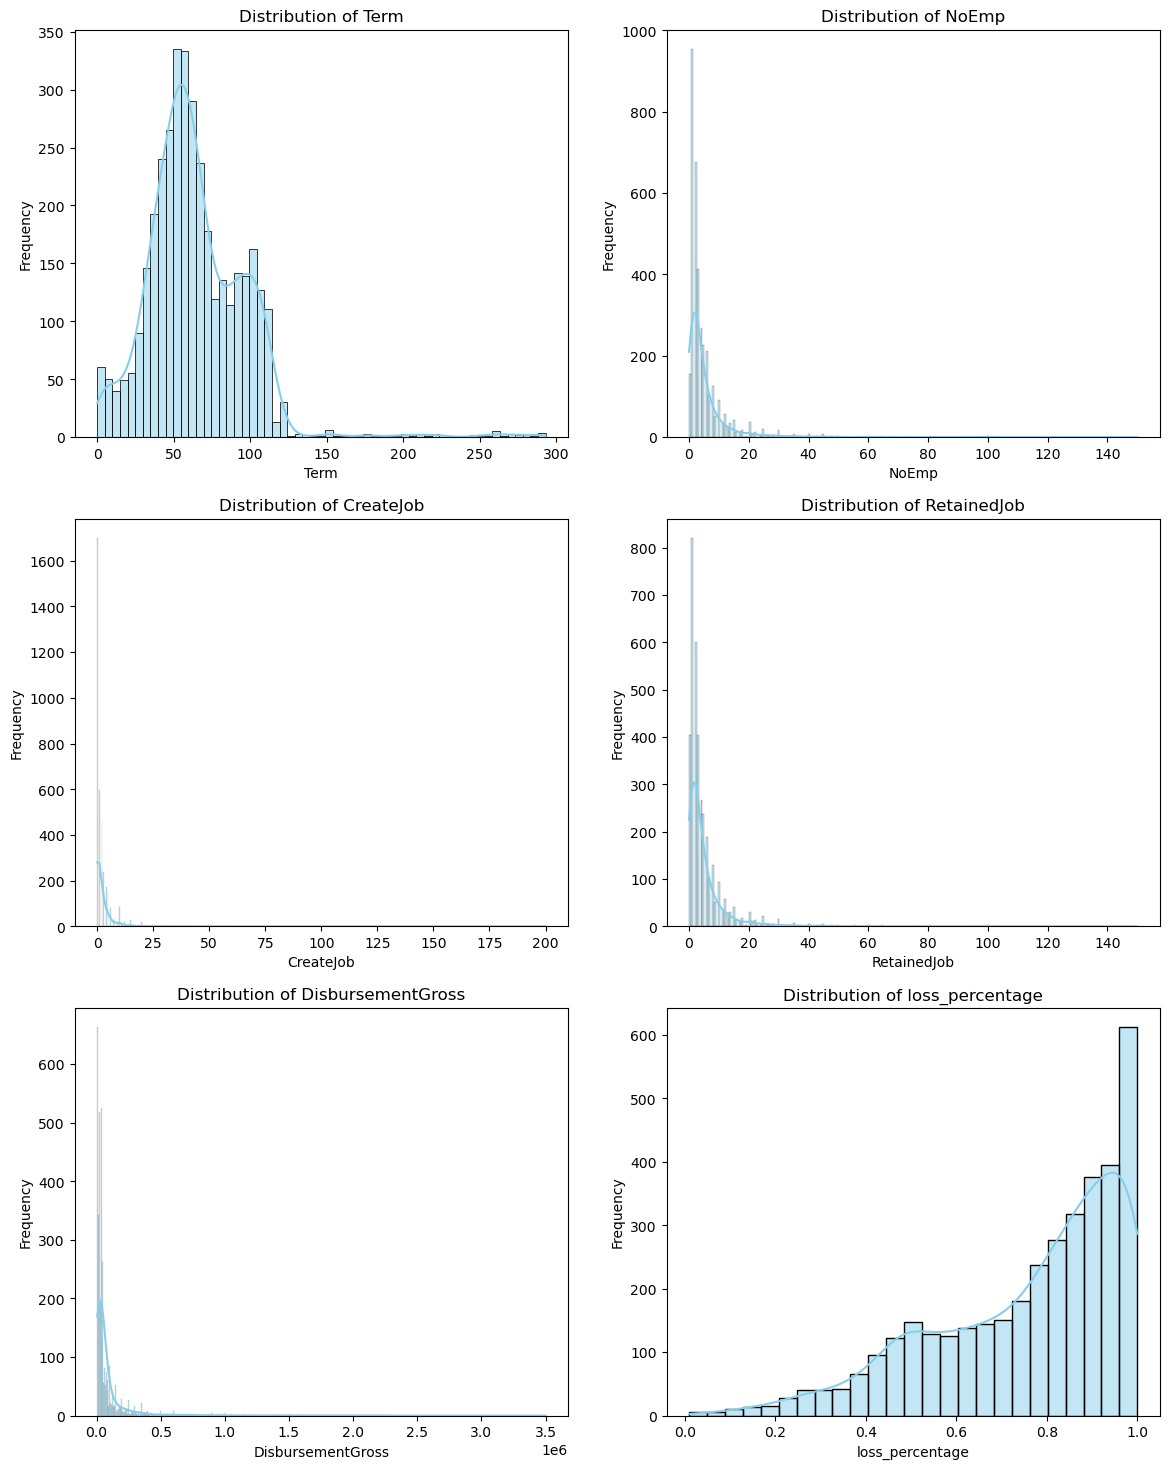

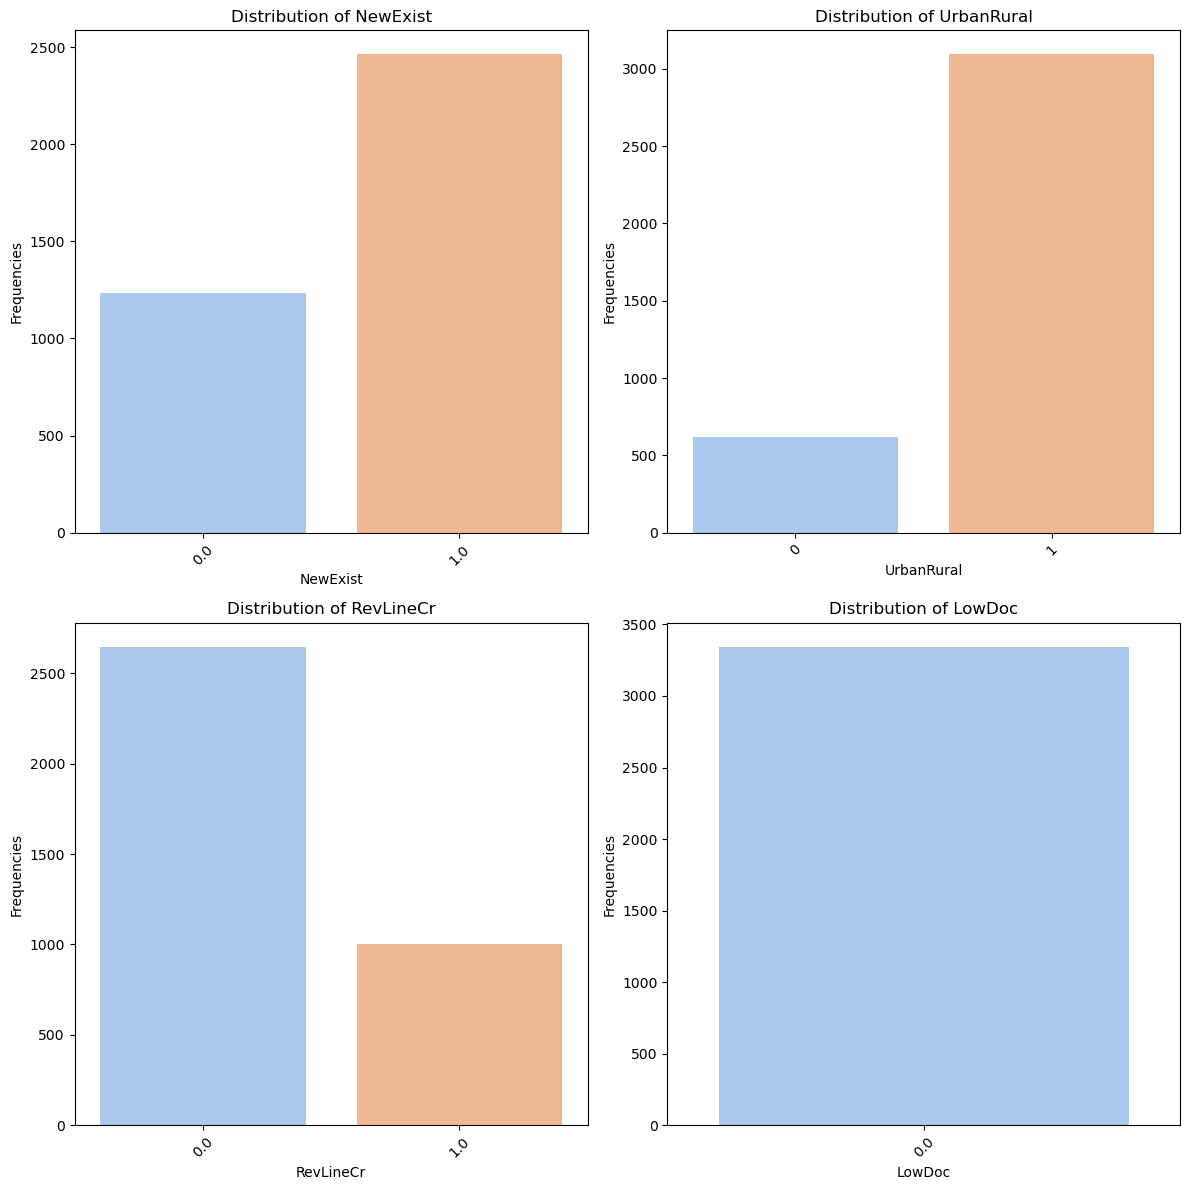

In [30]:
# Separate numerical and categorical columns
num_cols = df_reg.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df_reg.select_dtypes(include=['object']).columns

# Plot of numerical features along with boxplots wrt output
fig, axes = plt.subplots(3, 2, figsize=(14, 18)) 
axes = axes.ravel()

# Plot distribution for numerical variables
for i, col in enumerate(num_cols):
    sns.histplot(df_reg[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Frequencies for each categorical variable
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()

for i, col in enumerate(cat_cols):
    sns.countplot(x=df_reg[col], palette='pastel', ax=axes[i], hue=df_reg[col], legend=False)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequencies")
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

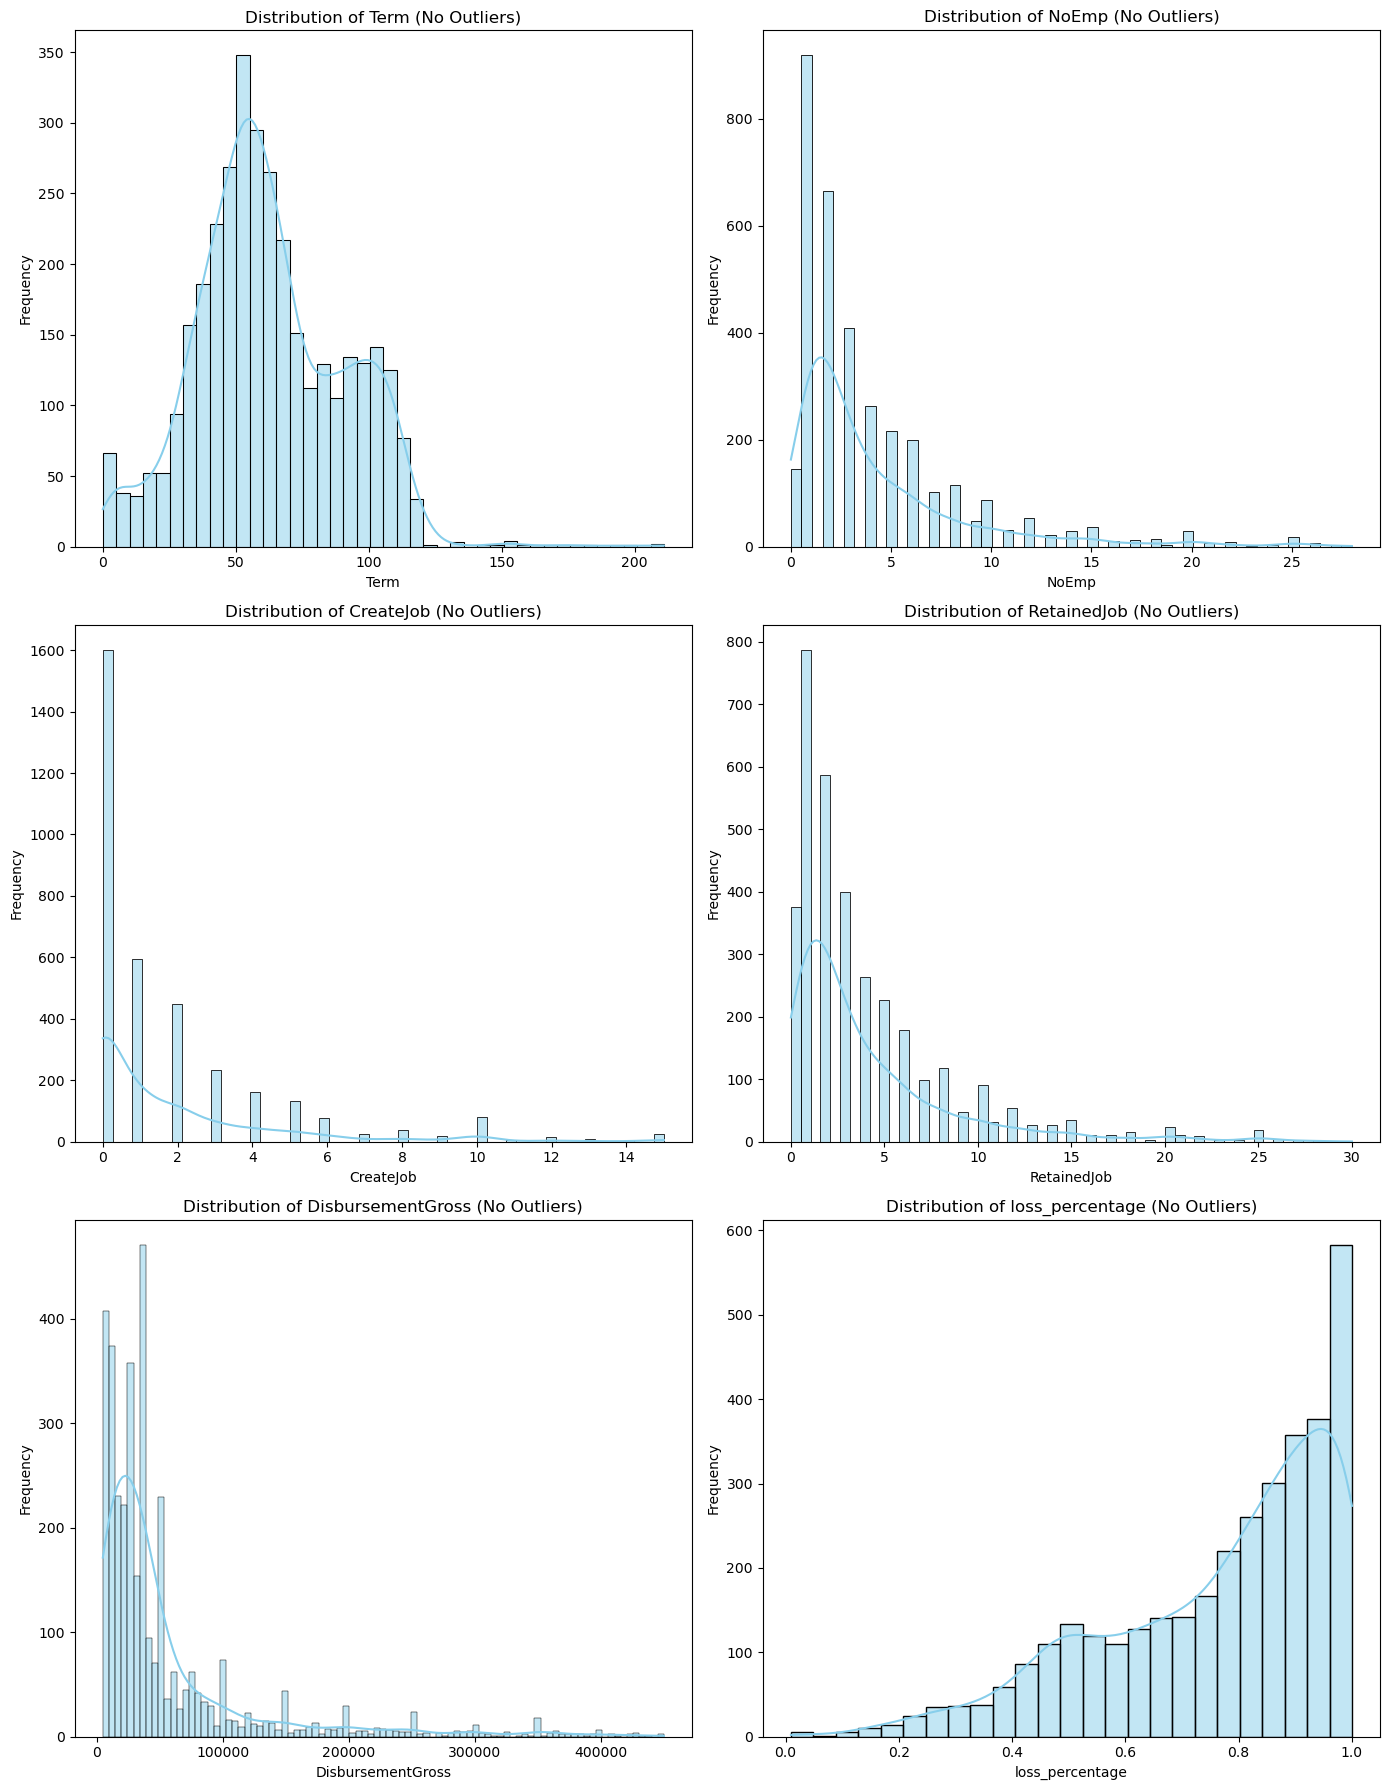

In [31]:
# Due to difficult in visualization, remove outliers from numerical variables
Q1 = df_reg[num_cols].quantile(0.1)
Q3 = df_reg[num_cols].quantile(0.9)
IQR = Q3 - Q1
df_no_outliers = df_reg.copy()

for col in num_cols:
    lower_bound = Q1[col] - 1.5 * IQR[col]
    upper_bound = Q3[col] + 1.5 * IQR[col]
    df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]

# Plot
fig, axes = plt.subplots(3, 2, figsize=(14, 18)) 
axes = axes.ravel()

for i, col in enumerate(num_cols):
    sns.histplot(df_no_outliers[col], kde=True, color='skyblue', ax=axes[i])
    axes[i].set_title(f"Distribution of {col} (No Outliers)")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [32]:
# Remove LowDoc since all zeros
df_reg = df_reg.drop(columns=["LowDoc"])

## PREDICTION

In [33]:
np.random.seed(19)

# One-hot encoding for categorical variables
df_reg["loss_percentage"] = df_reg["loss_percentage"].astype(float)
df_encoded = pd.get_dummies(df_reg, drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop(columns=['loss_percentage'])
y = df_encoded['loss_percentage']

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Splitting the dataset in 70% train, 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=19)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

Train set: (2598, 8)
Test set: (1114, 8)


### RANDOM FOREST

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best parameters for Random Forest Regressor:
{'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Train Set Metrics:
Residual Sum of Squares (RSS) on Train Set: 52.99870785636241
Root Mean Squared Error (RMSE) on Train Set: 0.1428279054256164
RMSE / Standard Deviation (RMSE/SD) on Train Set: 0.6713326793970753

Test Set Metrics:
Residual Sum of Squares (RSS) on Test Set: 28.683722200664224
Root Mean Squared Error (RMSE) on Test Set: 0.16046309273431122
RMSE / Standard Deviation (RMSE/SD) on Test Set: 0.7918732855469529


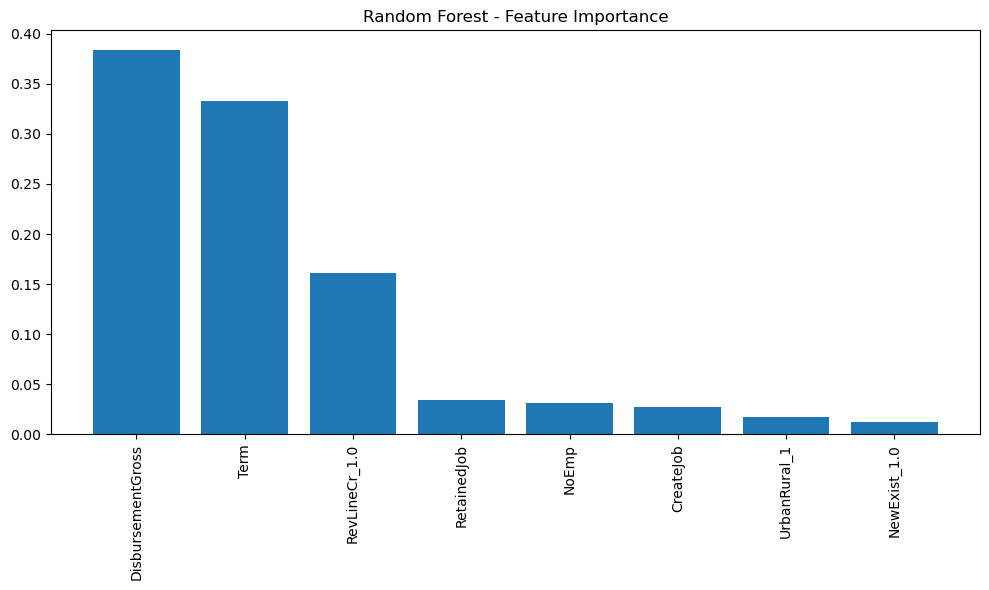

Summary Plot


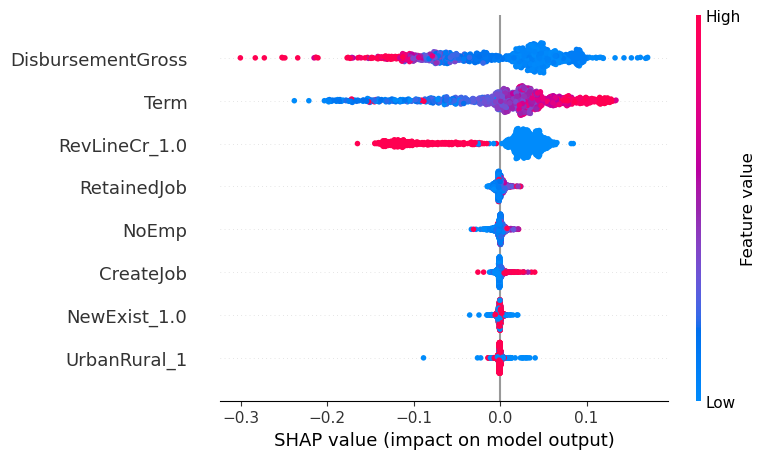

SHAP Bar Plot (Feature Importance)


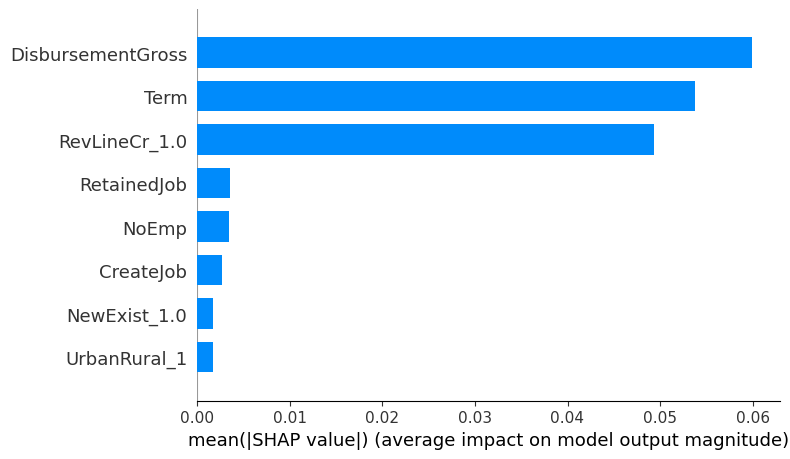

Dependence Plot for Term


<Figure size 1000x500 with 0 Axes>

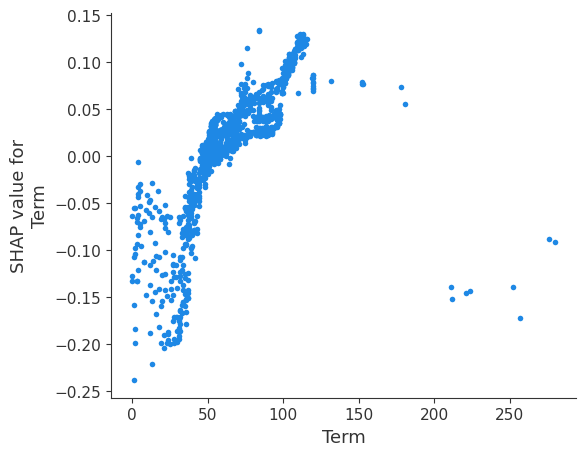

Dependence Plot for NoEmp


<Figure size 1000x500 with 0 Axes>

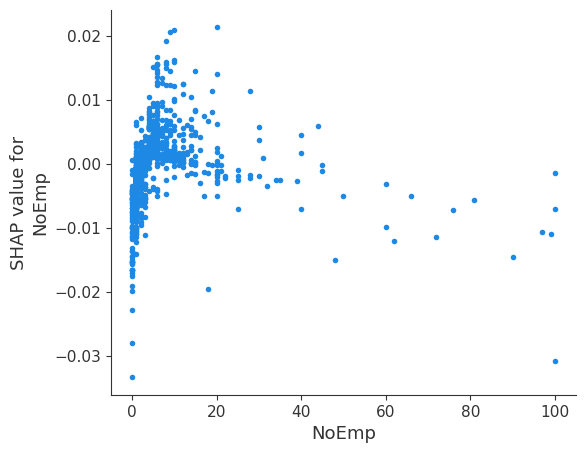

Dependence Plot for CreateJob


<Figure size 1000x500 with 0 Axes>

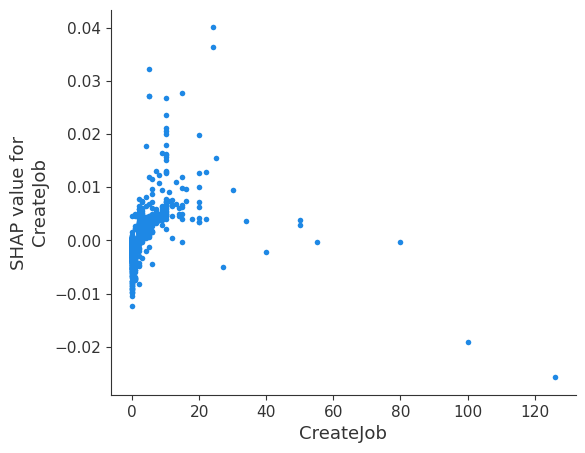

Dependence Plot for RetainedJob


<Figure size 1000x500 with 0 Axes>

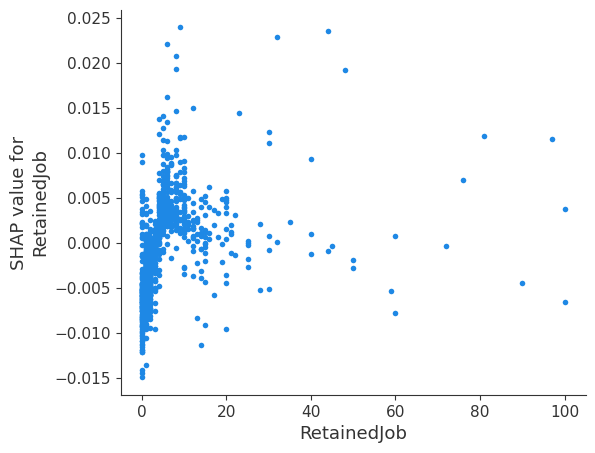

Dependence Plot for DisbursementGross


<Figure size 1000x500 with 0 Axes>

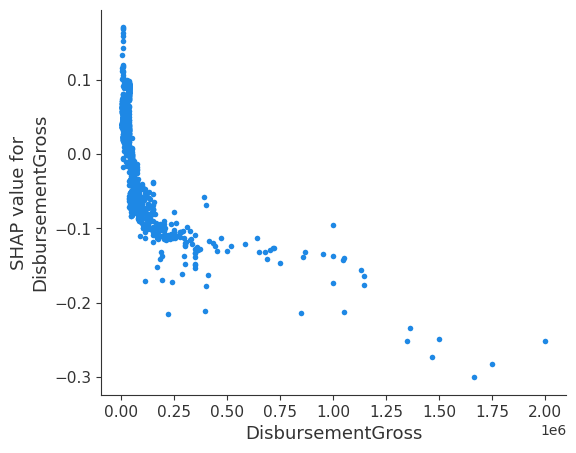

Dependence Plot for NewExist_1.0


<Figure size 1000x500 with 0 Axes>

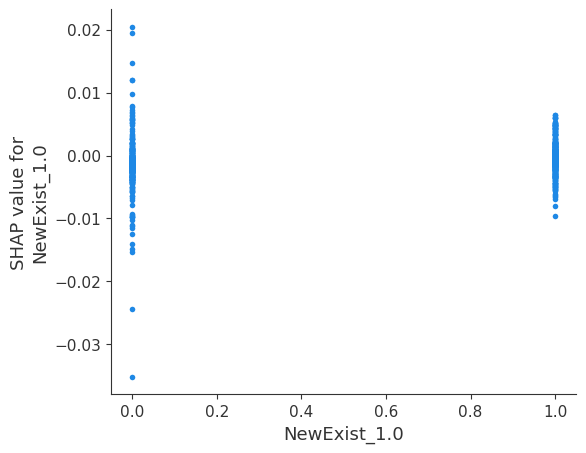

Dependence Plot for UrbanRural_1


<Figure size 1000x500 with 0 Axes>

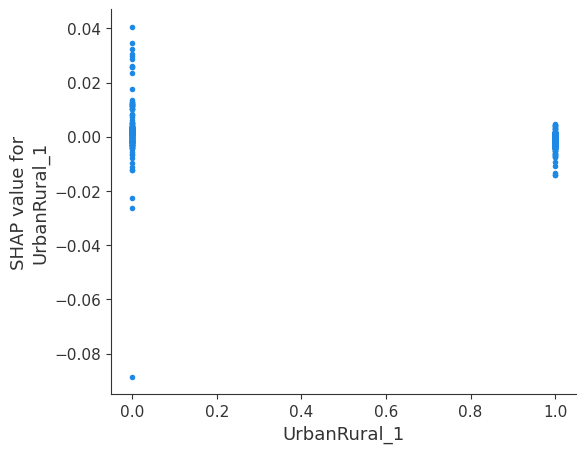

Dependence Plot for RevLineCr_1.0


<Figure size 1000x500 with 0 Axes>

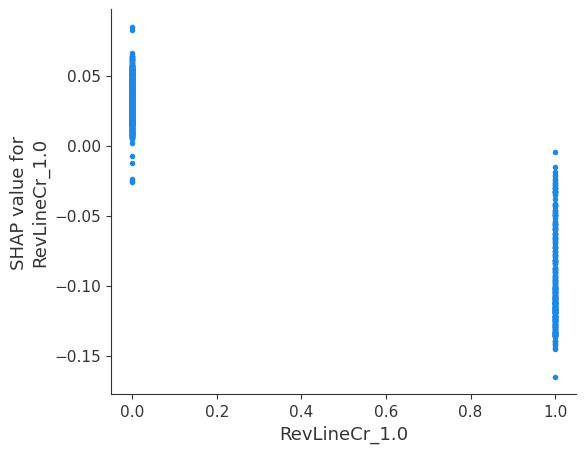

Calculating Banzhaf Values: 100%|██████████| 255/255 [00:34<00:00,  7.41coalition/s]


Banzhaf Values for each feature:
Term: 0.0802
NoEmp: 0.0067
CreateJob: 0.0052
RetainedJob: 0.0071
DisbursementGross: 0.0749
NewExist_1.0: 0.0047
UrbanRural_1: 0.0043
RevLineCr_1.0: 0.0507


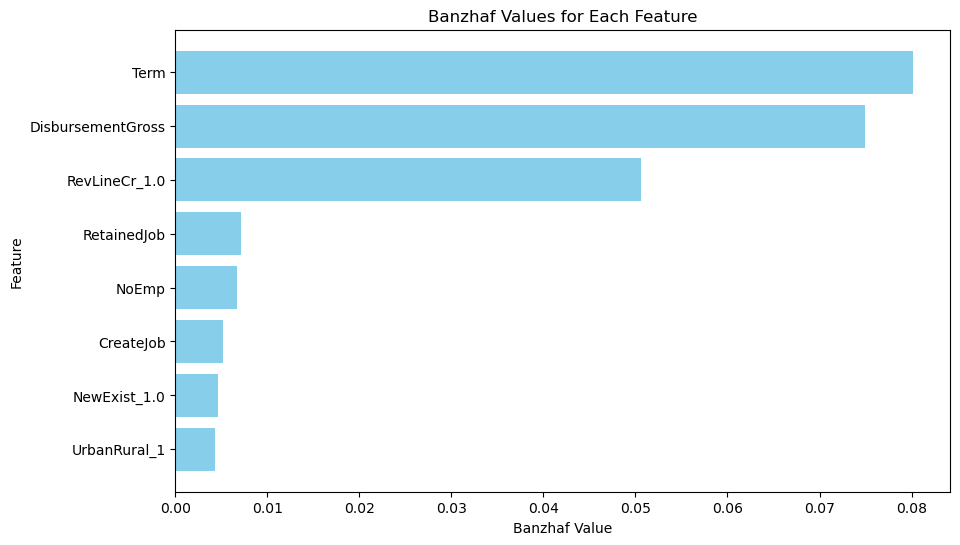

In [34]:
# Random Forest Regressor model
rf_regressor = RandomForestRegressor(random_state=19)

# Parameter grid for hyperparameter tuning using GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 150],
    'max_depth': [7, 10],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 3] 
}

# Perform GridSearchCV to find the best parameters
grid_search_rf = GridSearchCV(rf_regressor, param_grid_rf, cv=5, n_jobs=-1, verbose=2)
grid_search_rf.fit(X_train, y_train)

# Print the best hyperparameters for Random Forest
print("Best parameters for Random Forest Regressor:")
print(grid_search_rf.best_params_)

# Get the best model from the GridSearchCV results
best_rf = grid_search_rf.best_estimator_

# Predict on the train and test sets using the best model
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test)

# Calculate metrics for the train set
rss_train = np.sum((y_train - y_train_pred) ** 2)  # Residual Sum of Squares (RSS) for the train set
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Root Mean Squared Error (RMSE) for the train set
sd_train = np.std(y_train)  # Standard deviation of the actual output values for the train set
rmse_sd_train = rmse_train / sd_train  # RMSE divided by the standard deviation (RMSE/SD) for the train set

# Calculate metrics for the test set
rss_test = np.sum((y_test - y_test_pred) ** 2)  # Residual Sum of Squares (RSS) for the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))  # Root Mean Squared Error (RMSE) for the test set
sd_test = np.std(y_test)  # Standard deviation of the actual output values for the test set
rmse_sd_test = rmse_test / sd_test  # RMSE divided by the standard deviation (RMSE/SD) for the test set

# Print the metrics for the train and test sets
print(f"Train Set Metrics:")
print(f"Residual Sum of Squares (RSS) on Train Set: {rss_train}")
print(f"Root Mean Squared Error (RMSE) on Train Set: {rmse_train}")
print(f"RMSE / Standard Deviation (RMSE/SD) on Train Set: {rmse_sd_train}")

print(f"\nTest Set Metrics:")
print(f"Residual Sum of Squares (RSS) on Test Set: {rss_test}")
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
print(f"RMSE / Standard Deviation (RMSE/SD) on Test Set: {rmse_sd_test}")

# Feature importance: Get the importance scores for each feature
importances_rf = best_rf.feature_importances_

# Sort the feature importances in descending order
indices_rf = np.argsort(importances_rf)[::-1]

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), X.columns[indices_rf], rotation=90)
plt.tight_layout()
plt.show()

# SHAP
shap_analysis(best_rf, X_test, y_test, 3, 0)

# Banzhaf
banzhaf_value(best_rf, X_test, 0)

### XGBOOST

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for XGBoost:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'subsample': 0.7}
Train RSS: 32.725675201170816
Test RSS: 29.278571203670914
Train RMSE: 0.1122340757536048
Test RMSE: 0.16211841319102321
Train RMSE / SD: 0.5275327854931096
Test RMSE / SD: 0.8000421674147602


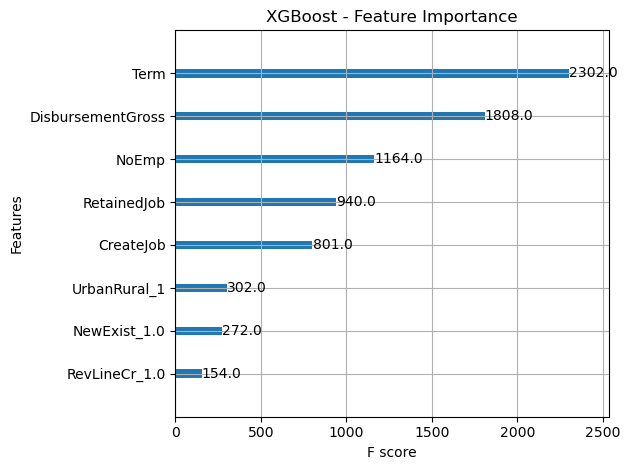

Summary Plot


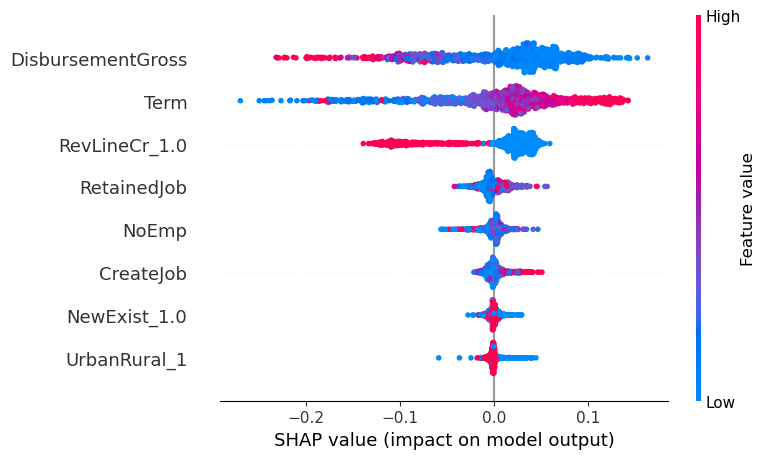

SHAP Bar Plot (Feature Importance)


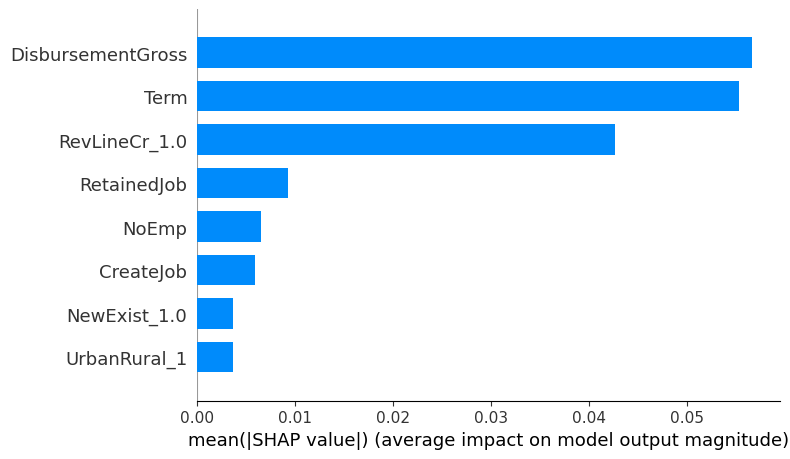

Dependence Plot for Term


<Figure size 1000x500 with 0 Axes>

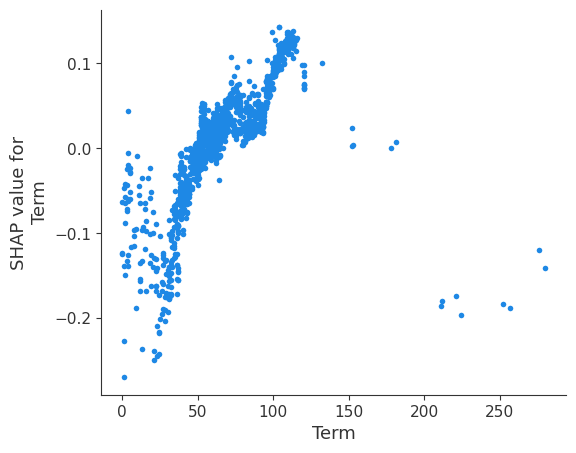

Dependence Plot for NoEmp


<Figure size 1000x500 with 0 Axes>

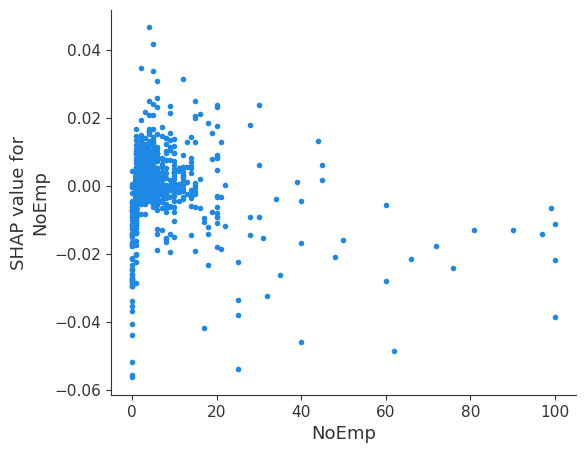

Dependence Plot for CreateJob


<Figure size 1000x500 with 0 Axes>

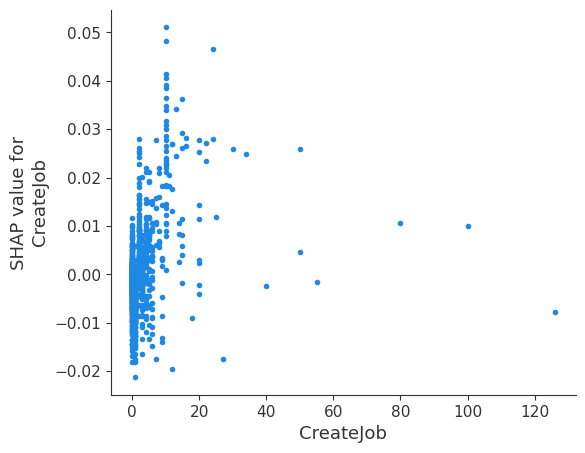

Dependence Plot for RetainedJob


<Figure size 1000x500 with 0 Axes>

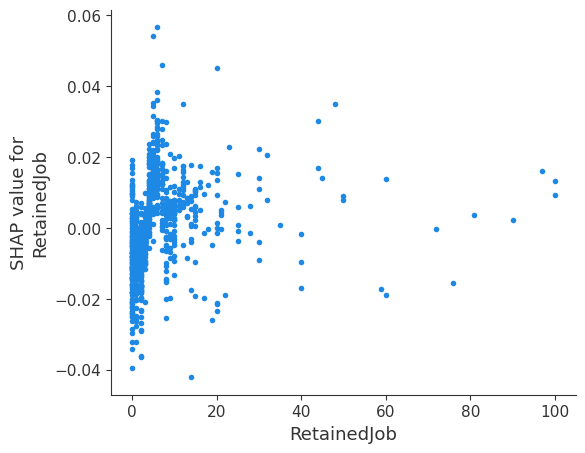

Dependence Plot for DisbursementGross


<Figure size 1000x500 with 0 Axes>

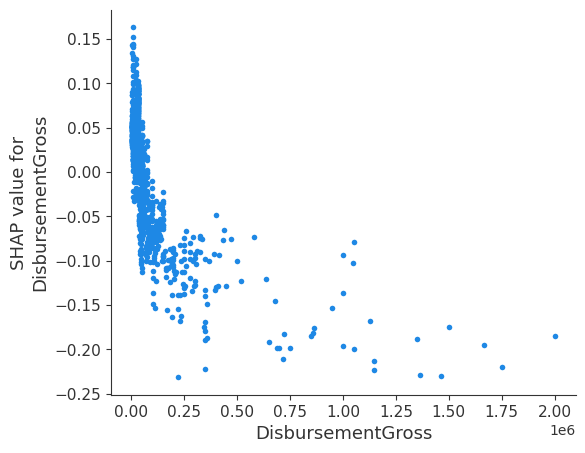

Dependence Plot for NewExist_1.0


<Figure size 1000x500 with 0 Axes>

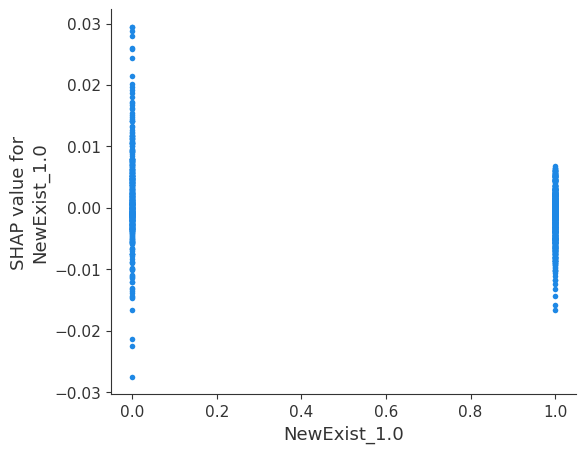

Dependence Plot for UrbanRural_1


<Figure size 1000x500 with 0 Axes>

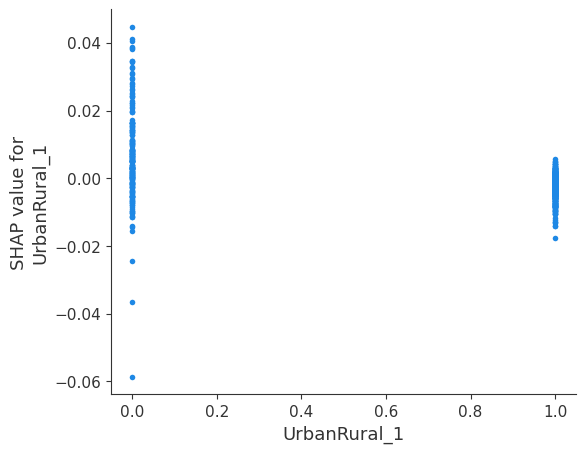

Dependence Plot for RevLineCr_1.0


<Figure size 1000x500 with 0 Axes>

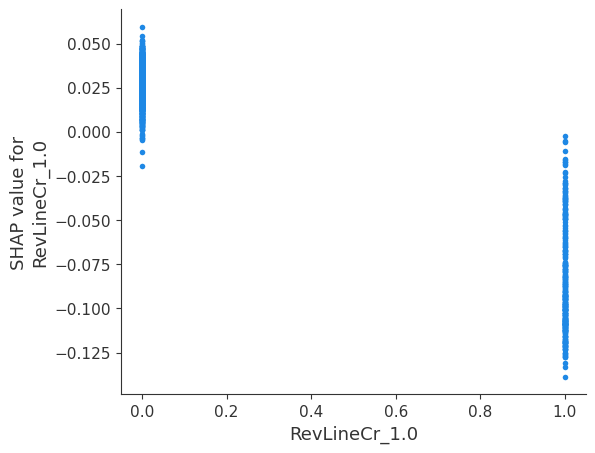

Calculating Banzhaf Values: 100%|██████████| 255/255 [00:14<00:00, 17.23coalition/s]


Banzhaf Values for each feature:
Term: 0.0871
NoEmp: 0.0179
CreateJob: 0.0141
RetainedJob: 0.0200
DisbursementGross: 0.0793
NewExist_1.0: 0.0093
UrbanRural_1: 0.0079
RevLineCr_1.0: 0.0436


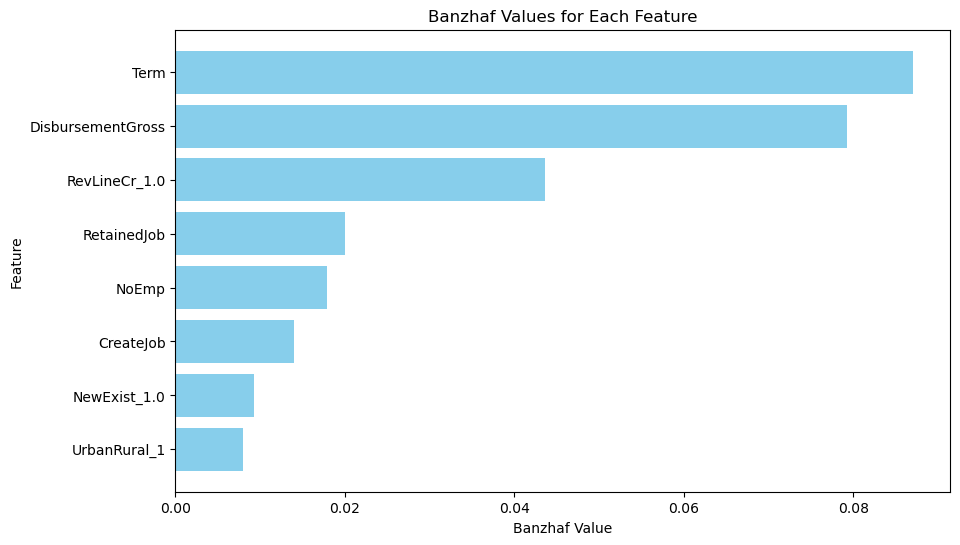

In [35]:
# XGBoost Regressor
xgb_model = XGBRegressor(random_state=19, eval_metric='rmse')

param_grid_xgb = {
    'n_estimators': [100, 150],
    'max_depth': [7, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# GridSearch
grid_search_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)
print("Best parameters for XGBoost:")
print(grid_search_xgb.best_params_)

# Model performances
best_xgb = grid_search_xgb.best_estimator_

# Evaluate the model with the training and testing sets
y_train_pred = best_xgb.predict(X_train)
y_test_pred = best_xgb.predict(X_test)

# RSS (Residual Sum of Squares)
rss_train = ((y_train - y_train_pred) ** 2).sum()
rss_test = ((y_test - y_test_pred) ** 2).sum()

# RMSE (Root Mean Square Error)
rmse_train = np.sqrt(np.mean((y_train - y_train_pred) ** 2))
rmse_test = np.sqrt(np.mean((y_test - y_test_pred) ** 2))

# RMSE / Standard Deviation
rmse_train_sd = rmse_train / np.std(y_train)
rmse_test_sd = rmse_test / np.std(y_test)

# Print Metrics
print(f"Train RSS: {rss_train}")
print(f"Test RSS: {rss_test}")
print(f"Train RMSE: {rmse_train}")
print(f"Test RMSE: {rmse_test}")
print(f"Train RMSE / SD: {rmse_train_sd}")
print(f"Test RMSE / SD: {rmse_test_sd}")

# Feature Importance Plot
xgb.plot_importance(best_xgb, importance_type='weight', max_num_features=15, title="XGBoost - Feature Importance")
plt.tight_layout()
plt.show()

# SHAP
shap_analysis(best_xgb, X_test, y_test, 3, 0)

# Banzhaf
banzhaf_value(best_xgb, X_test, 0)